Created on Fri Mar  3 20:03:23 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 3.3 更新策略

## 3.3.1 1维度权重决策、复杂网络更新和2维度布局优化——空间决策支持系统

In [1]:
# IPython extension to reload modules before executing user code.
%load_ext autoreload 
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2 
from usda import datasets as usda_datasets
from usda import data_visualization as usda_vis
from usda import pattern_signature as usda_signature
from usda import utils as usda_utils
from usda import meta_heuristics as usda_heuristicsw
from usda import network as usda_network

import mapclassify
import numpy  as np
import cc3d
import copy
import matplotlib.pyplot as plt
import random
import itertools
import networkx as nx
from networkx.algorithms import approximation as approx
import math
from toolz import partition
from collections import defaultdict
from scipy.signal import convolve2d

np.set_printoptions(linewidth=np.inf)

### 3.3.1.1 1维度权重决策

在“权重决策”一章，对于 BWM 和 IDOCRIW方法分别采用了GWO 和 GA 元启发式算法求解方程组。元启发式算法（优化算法）通常用于存在许多可能解决方案（多备选方案）的多变量（多准则）问题中，并且结果会根据这些变量的组合不同发生较大的变化。优化算法通过评分（由约束条件（constraints）给出）许多不同的解决方案确定它们的质量（对评分结果进行排序）来找到问题的最佳答案（题解）。优化算法通常用于由于解决的方案太多而无法全部遍历尝试的情况<sup>[Segaran, T. Programming Collective Intelligence. (O’Reilly, 2007).]</sup>。 Toby Segaran <sup>[Segaran, T. (2007)]</sup>提供了多个解释优化算法的案例，其中学生宿舍优化问题为根据人们的偏好分配有限资源的问题，如果延申该问题至城市空间规划领域，可以提出根据不同建设内容分配有限不同土地资源条件问题，例如根据约束条件设置，假设考虑到绿地、水体、生活服务、美食购物、教育培训、交通，建设成本等条件，存在5类不同条件的地块，

1. 地块A，绿地水体面积占比大，但其它条件偏弱，建设成本高；
2. 地块B，绿地水体面积占比偏中，有丰富的教育资源，交通条件良好，但生活服务、美食购物条件差，建设成本高；
3. 地块C，绿地水体面积占比偏中，生活服务、美食购物和交通条件好，但缺少教育资源，建设成本高；
4. 地块D，绿地少，无水体，无教育资源，但生活服务、美食购物和交通条件好，建设成本高中；
5. 地块E，裸地，建设成本低，除交通外，无其它资源。

对应变量为`plots`。

根据调研，地块A、B和C均有1个区域可选择，地块D和E有2个区域可选择，总共可选择区域数为7个，正好对应7个建设项目，每个建设项目给出首选和次选两个选择（对应变量为`prefs`），这很有可能发生用地配置冲突，那么如何协调分配，尽可能满足各建设项目的需求，面对存在多种甚至无数种解的问题，优化算法为从这些答案中寻找最优解提供了思路。

解决此问题的关键是，每个项目只能对应到一个地块区域和成本如何计算（定义目标函数）。Toby Segaran 在解决此问题时，给出了一个巧妙地解决思路，对于第1个问题，7个项目在选择地块时，采取逐一选择的策略，即第1个项目选择了一个地块后，随即将该地块从列表`plots_idx`下移除，那么第2个项目选择时仅从剩余的地块中选择。此时，优化的“权重”列表（chromosome），实际上为用于选择剩余地块列表的索引值，这也解释了参数`domain`“权重”值区间的设定为什么为`[(0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 0)]`。对于第1个项目，此时有7个地块可以选择，因此区间均为`(0,6)`，而到第2个项目时，因为已经由第1个项目选择排除了一个，因此区间为`(0,5)`，以此类推。对于第2个问题，如果项目选择的地块为首选地块，则成本为0；如果为次选地块，则成本为1；如果均不在首选和次选中，则成本为3，因此成本值越小越趋于最优解。

In [5]:
plots=['p_a','p_b','p_c','p_d','p_e']
prefs=[('s_1',('p_d','p_c')),
       ('s_2',('p_a','p_e')),
       ('s_3',('p_a','p_e')),
       ('s_4',('p_b','p_a')),
       ('s_5',('p_d','p_b')),
       ('s_6',('p_c','p_e')),
       ('s_7',('p_e','p_b'))]

domain=[(0,7-i-1) for i in range(0,7)]
print(domain)

# 构建目标函数
def target_function_plot_allocation(vec):
    cost=0
    plots_idx=[0,1,2,3,3,4,4]
    for i in range(len(vec)):
        x=int(vec[i])
        plot=plots[plots_idx[x]]
        pref=prefs[i][1]
        if pref[0]==plot: cost+=0
        elif pref[1]==plot: cost+=1
        else: cost+=3
        
        del plots_idx[x]
    
    return cost

best_score,epoch=usda_heuristicsw.genetic_algorithm_SegarantT(domain,target_function_plot_allocation,popsize=20,maxiter=100,verbose=20)

[(0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 0)]
iter_0: cost=6
iter_20: cost=1
iter_40: cost=1
iter_60: cost=1
iter_80: cost=1


打印对应迭代成本变化曲线。对于该实验，因为涉及的数据量小，快速收敛。

因为优化算法是趋于最优解，种群（population）的初始化，变异（mutation）和交叉（crossover）或配对（breeding）都应用了随机数生成随机基因（gene）的染色体（chromosome），筛选部分种群变异，从精英选拔（elitism）的染色体中随机选择父类通过交叉获取子类等过程，因此不同执行优化过程结果可能不同。

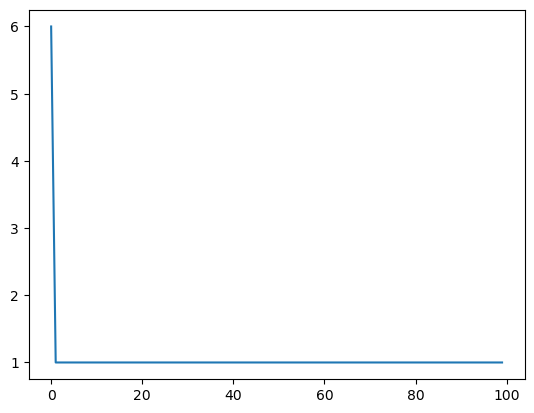

In [6]:
fig, ax=plt.subplots()
ax.plot(epoch.keys(),epoch.values())
plt.show()

因为“权重”列表为选择剩余地块的索引值，因此需要将计算结果返回为各个项目实际选择的地块。从上述计算结果看，7个项目中有6个保持了首选，有1个为次选，为一个不错的优化计算结果，能够满足绝大多项目的最佳需求。

In [7]:
def print_solution(vec):
    slots=[0,1,2,3,3,4,4]
    # Loop over each students assignment
    for i in range(len(vec)):
        x=int(vec[i])
        # Choose the slot from the remaining ones
        plot=plots[slots[x]]
        
        if plot in prefs[i][1]:
            priority=prefs[i][1].index(plot)
        else:
            priority=-1
        # Show the student and assigned dorm
        print (f'{prefs[i][0]}: {plot}; priority: {priority}')
        # Remove this slot
        del slots[x]
        
print(best_score)  
print('-'*50)
print_solution(best_score)

[3, 4, 0, 0, 1, 0, 0]
--------------------------------------------------
s_1: p_d; priority: 0
s_2: p_e; priority: 1
s_3: p_a; priority: 0
s_4: p_b; priority: 0
s_5: p_d; priority: 0
s_6: p_c; priority: 0
s_7: p_e; priority: 0


根据解决问题的不同，在保持遗传算法基本思想不变的条件下，涉及到的选择、变异和交叉等具体内容时，会根据具体问题相应变化。Toby Segaran 提供的上述代码变异部分为对随机一个染色体的基因执行变化，如果该基因值大于给定区间（`domain`）最小值，且生成的[0,1]随机数小于0.5，则减去`step`步幅值；如果该基因值小于给定区间最大值则加上`step`步幅值。步幅值`step`根据“权重”配置确定，例如本例“权重”为地块选择索引值，因此配置值为1。交叉部分的方法根据随机一个整数值（区间为0到“权重”列表长度，即染色体的长度）交换染色体前后部分。在*权重决策*部分给出的遗传算法，为 Valdecy Pereira 就 MCDM 问题给出的适合解法，在选择、变异和交叉等计算上保持遗传算法基本思想不变条件下，与 Toby Segaran 提供的方法不同，具体可以查看*权重决策*部分的解释。 

虽然 Toby Segaran 和 Valdecy Pereira 提供的遗传算法具体计算方式有所差异，核心仍旧是根据目标函数（计算成本值）寻找最优解的过程，因此将选择分配问题也以 Valdecy Pereira 提供的方法进行计算，参数的配置保持相同，虽然返回值为浮点数（可以调整原代码，转换为整数形式，适合此次问题形式），但取其整数后，其结果与 Toby Segaran 结果同（需要注意不同次运行优化算法，可能结果不同）。

In [18]:
domain_min=[i[0] for i in domain]
domain_max=[i[1] for i in domain]
best_score_2,epoch_2=usda_heuristicsw.genetic_algorithm(population_size=20,
                                                        mutation_rate=0.2,
                                                        elite=4,
                                                        min_values=domain_min,
                                                        max_values=domain_max,
                                                        generations=100,
                                                        target_function=target_function_plot_allocation,
                                                        verbose=20)

Generation =  0  f(x) =  1.0
Generation =  20  f(x) =  1.0
Generation =  40  f(x) =  1.0
Generation =  60  f(x) =  1.0
Generation =  80  f(x) =  1.0
Generation =  100  f(x) =  1.0


In [23]:
print(best_score_2[:-1])  
print('-'*50)
print_solution(best_score_2[:-1])

[3.43977778 4.38075696 0.14946282 0.43850957 1.08662738 0.11878839
 0.        ]
--------------------------------------------------
s_1: p_d; priority: 0
s_2: p_e; priority: 1
s_3: p_a; priority: 0
s_4: p_b; priority: 0
s_5: p_d; priority: 0
s_6: p_c; priority: 0
s_7: p_e; priority: 0


### 3.3.1.2 复杂网络更新

Toby Segaran 提供的“绘制网络”的实验，虽然其目的是为了可视化网络结构时，避免绘制边线的交叉，但是由此可以拓展到复杂网络应用元启发式算法，在约束条件控制下，生成或更新网络的方法。这里给出一个探索性实验，将廊道和斑块（节点
）的结构关系表述为复杂网络的形式，通过给定约束条件，1， 连通性；2，传递性；3，最近邻指数（点分布）；4. 避免边交叉，来生成一个根据约束条件可调的复杂网络形态。该实验分两个阶段，第1阶段为生成图；第2阶段为布局图。

#### 1) 生成图（廊道的连通性和传递性）

如果廊道具有较高的连通性（各个斑块之间有路线联系），斑块或节点之间形成环路或存在可替代路线，那么物种可以在廊道中有效移动，且避免廊道间隙、干扰、捕食者或者狩猎者的负面影响，提高移动效率<sup>[Weiss, J. Landscape Ecology Principles In Landscape Architecture And Land Use Planning. in (2016).]</sup>。对应连通性和环路，在*图属性的基本度量*一章提到``NetworkX`库的`node_connectivity`方法可以计算顶点连通度（断开网络需要移除的最少边数）；`transitivity`方法可以计算传递性（为三角形（triangle）占三元（triads，为共享顶点的两个边）的比例）。生成图的思路借鉴了“学生宿舍优化问题”，基本流程为：

1. 通过指定顶点数`nodes_n`，生成顶点（名称）列表`ndoes`，进而构建全部可成对的边`pairs`列表；
2. 指定生成图的边数`edges_n`，根据边数构建索引值区间（“权重”取值范围）`domain`，方法同“学生宿舍优化问题”，只是从全部可成对的边`pairs`列表中选择部分边，例如下述实验边列表有36个边，而提取的边数为12；
3. 构建目标函数。根据提取的边构建图`G`，计算图的连通性和传递性，并通过分别被最大潜在连通性和值1减，将最大问题转换为最小问题；
4. 在连通性和传递性的贡献度分配上，增加了一个[0,1]区间的参数`w`来调整哪个指数具有更高的影响。

为了方便构建`target_function_network()`目标函数，一般先随机生成一个随机值（本例为索引值）列表`edges_idx`，用于传入函数调试代码。

In [128]:
nodes_n=9
edges_n=12
w=0.7

complete_G=nx.complete_graph(nodes_n)
connectivity_complete=approx.node_connectivity(complete_G)
print(connectivity_complete)

nodes=[f'n_{i}' for i in range(nodes_n)]
pairs=list(itertools.combinations(nodes,2))
print(len(pairs)) 

domain=[(0,len(pairs)-i-1) for i in range(edges_n)]
print(domain)
edges_idx=[random.randint(i[0],i[1]) for i in domain] # 用于辅助构建目标函数而生成的随机“权重”值

# 构建目标函数
def target_function_network(edges_idx):
    global pairs,connectivity_complete,w

    pairs_copy=copy.deepcopy(pairs)    
    edges=[]
    for i in range(len(edges_idx)):
        x=int(edges_idx[i])
        pair=pairs_copy[x]
        edges.append(pair)
        del pairs_copy[x]

    G=nx.Graph()
    G.add_edges_from(edges)   
    connectivity_=(connectivity_complete-approx.node_connectivity(G))/connectivity_complete
    transitivity_=1-nx.transitivity(G)
    
    cost=connectivity_*w+transitivity_*(1-w)

    return cost

cost=target_function_network(edges_idx)    
print(cost)

8
36
[(0, 35), (0, 34), (0, 33), (0, 32), (0, 31), (0, 30), (0, 29), (0, 28), (0, 27), (0, 26), (0, 25), (0, 24)]
0.7431818181818182


使用遗传算法寻找最优解。

In [149]:
best_idx_1,_=usda_heuristicsw.genetic_algorithm_SegarantT(domain,target_function_network,step=1,popsize=50,maxiter=501,verbose=100)

iter_0: cost=0.6449999999999999
iter_100: cost=0.5923387096774193
iter_200: cost=0.5923387096774193
iter_300: cost=0.5923387096774193
iter_400: cost=0.5923387096774193
iter_500: cost=0.5923387096774193


最优解为索引值列表，需要将其转换回对应的边，并构建图，打印图查看结果。

node connectivity=3;
transitivity=0.4838709677419355


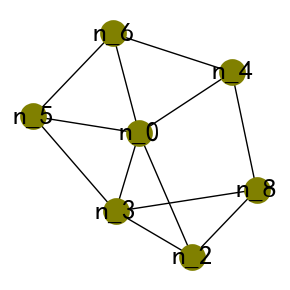

In [150]:
def show_G_solution(best_idx):
    global pairs

    pairs_copy=copy.deepcopy(pairs)    
    edges=[]
    for i in range(len(best_idx)):
        x=int(best_idx[i])
        pair=pairs_copy[x]
        edges.append(pair)
        
        del pairs_copy[x]
        
    G=nx.Graph()
    G.add_edges_from(edges)
    print(f'node connectivity={approx.node_connectivity(G)};\ntransitivity={nx.transitivity(G)}')
    usda_network.G_drawing(G)
    
    return G
    
G_1=show_G_solution(best_idx_1)

同样使用了 Valdecy Pereira 提供的遗传算法生成图，转换索引、打印查看图。

In [169]:
domain_min=[i[0] for i in domain]
domain_max=[i[1] for i in domain]
best_idx_2,_=usda_heuristicsw.genetic_algorithm(
    population_size=50,
    mutation_rate=0.2,
    elite=8,
    min_values=domain_min,
    max_values=domain_max,
    generations=500,
    target_function=target_function_network,
    verbose=100)

Generation =  0  f(x) =  0.6916666666666667
Generation =  100  f(x) =  0.5006578947368421
Generation =  200  f(x) =  0.5006578947368421
Generation =  300  f(x) =  0.45
Generation =  400  f(x) =  0.45
Generation =  500  f(x) =  0.45


node connectivity=1;
transitivity=0.6


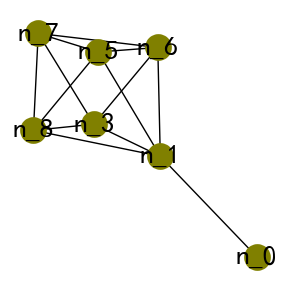

In [179]:
G_2=show_G_solution(best_idx_2)

#### 2)  布局图（最近邻指数和避免廊道交叉）

生成的图具有顶点和边，但是还没有为顶点指定地理空间位置。确定位置坐标的约束条件给了两个，一个是最近邻指数；再者为避免廊道交叉。

最近邻指数（Nearest Neighbor Index，NNI），计算各个点与其最近点的距离之和除以点数量，求得一个平均距离。如果该平均距离小于假设随机分布的平均距离值，则被分析的点分布呈聚类趋势；如果该平均距离大于假设分布的平均距离值，则被分析的点分布呈分散趋势。观测平均距离与预期平均距离的比值即为最近邻指数（或称为平均最近邻比率（average nearest neighbor ratio，ANN））。其计算公式为：$A N N=\frac{\bar{D}_O}{\bar{D}_E}$， 式中，$\bar{D}_O$为观测平均距离，公式为：$\bar{D}_O=\frac{\sum_{i=1}^n d_i}{n}$，$d_i$为第$i$个点与其最近点距离，$n$为点数量；$\bar{D}_E$为预期平均距离，公式为：$\bar{D}_E=\frac{0.5}{\sqrt{n / A}}$，$A$为所有点最小外接矩形面积或者为指定的一个面积值。最近邻指数的统计标准差（z-score）为：$z=\frac{\bar{D}_O-\bar{D}_E}{S E}$，式中，$S E=\frac{0.26136}{\sqrt{n^2 / A}}$<sup>[Tong, Z. A genetic algorithm approach to optimizing the distribution of buildings in urban green space. Autom Constr 72, 46–51 (2016).][Clark, P. J. & Evans, F. C. Distance to Nearest Neighbor as a Measure of Spatial Relationships in Populations. Ecology 35, 445–453 (1954).][How Average Nearest Neighbor works, <https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-average-nearest-neighbor-distance-spatial-st.htm>]</sup>。
    
如果NNI（ANN）小于1，则点模式表现为集聚；如果该指数大于1，则趋于分散。
    
* 完全空间随机（complete spatial randomness，CSR），p-value与 z-score
    
在*空间自相关分析*部分解释邻接数时，确定两两一对单元BB（高值-高值），WW（低值-低值）分布是趋于集聚而不是完全随机分布时，通过生成完全空间随机（CSR）参照数据，构建一个参考分布来估计分析对象的统计意义。同样，对于NNI，采取了同样计算的思路，观察观测平均距离在由完全随机点数据集计算的预期平均距离分布上的位置，即由统计显著性水平（significance level）或临界值（critical value）分析 NNI 集聚或分散的显著性。p-value为一个概率，在地理空间模式分析（pattern analysis）中，为观测的空间模式由某个随机过程创建的概率。当p-value非常小时，意味着观测到的空间模式不太可能是随机的结果，因此拒绝原假设。z-score为一个标准差，可以通过标准差判断空间模式是否为小概率事件（例如空间点分布集聚、分散是否是随机结果等），p-value与 z-score的关系如图<sup>[What is a z-score? What is a p-value?, <https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm>]</sup>：
    
<img src="../imgs/3_3/3_3_01.png" height='auto' width='auto' title="caDesign">  
    
避免廊道（边）交叉的基本思路是计算每条边交叉的边的分数值（fraction）。如果对于两条边，该分数介于0（边的一个端点）和1（边的另一端点）之间，则它们相互交叉；如果分数不在0和1之间，则边不交叉。下述迁移和调整了 Toby Segaran 的代码，并增加了NNI计算部分。因为避免边的交叉（`total`）和 NNI 值`ann`数量级存在差异，因此通过增加参数`mu`调整`total`值大小；为了控制NNI的集聚程度，增加了参数`nu`，公式为：$C= T^{ \frac{1}{ \mu +1} }+  |  \nu -A |  $，式中，$C$为目标函数返回值（成本值）；$T$为避免边的交叉值；$A$为NNI值；$\mu$和$\nu$为对应调整的参数值。

In [375]:
# 构建目标函数
def target_function_cross_nni(coords):
    global G,planning_area
    
    pts=list(G_2.nodes)      
    links=list(G.edges)
    # Convert the number list into a dictionary of pts:(x,y)
    loc=dict([(pts[i],(coords[i*2],coords[i*2+1])) for i in range(0,len(pts))])
    total=0
    
    # Loop through every pair of links
    for i in range(len(links)):
        for j in range(i+1,len(links)):    
            # Get the locations 
            (x1,y1),(x2,y2)=loc[links[i][0]],loc[links[i][1]]
            (x3,y3),(x4,y4)=loc[links[j][0]],loc[links[j][1]]

            den=(y4-y3)*(x2-x1)-(x4-x3)*(y2-y1)      
            # den==0 if the lines are parallel
            if den==0: continue            
            
            # Otherwise ua and ub are the fraction of the
            # line where they cross
            ua=((x4-x3)*(y1-y3)-(y4-y3)*(x1-x3))/den
            ub=((x2-x1)*(y1-y3)-(y2-y1)*(x1-x3))/den            

            # If the fraction is between 0 and 1 for both lines
            # then they cross each other
            if ua>0 and ua<1 and ub>0 and ub<1:
                total+=1      
                
        for i in range(len(pts)):
            for j in range(i+1,len(pts)):               
                # Get the locations of the two nodes
                (x1,y1),(x2,y2)=loc[pts[i]],loc[pts[j]]

                # Find the distance between them
                dist=math.sqrt(math.pow(x1-x2,2)+math.pow(y1-y2,2))
                # Penalize any nodes closer than 50 pixels
                if dist<50:
                    total+=(1.0-(dist/50.0))
    
    ann,_=usda_network.nni(list(partition(2,coords)),planning_area)   
    mu=1
    nu=0.5
    cost=pow(total,1/(mu+1))+abs(nu-ann)

    return cost

G=G_2.copy()   
planning_area=10000
domain=[(0,100)]*(len(list(G_2.nodes) )*2)
print(domain)
vec=[float(random.randint(domain[i][0],domain[i][1])) for i in range(len(domain))] # 用于辅助构建目标函数而生成的随机“权重”值

target_function_cross_nni(vec)   

[(0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100)]


7.726449995062749

In [376]:
best_position,_=usda_heuristicsw.genetic_algorithm_SegarantT(domain,target_function_cross_nni,popsize=50,maxiter=501,verbose=100)

iter_0: cost=7.031376551186095
iter_100: cost=5.618358288334813
iter_200: cost=5.299805705965022
iter_300: cost=5.299805705965022
iter_400: cost=5.299805705965022
iter_500: cost=5.299805705965022


{'n_6': (27, 40), 'n_7': (27, 100), 'n_1': (84, 23), 'n_5': (67, 70), 'n_8': (100, 100), 'n_3': (0, 0), 'n_0': (0, 82)}
2.272290356842483


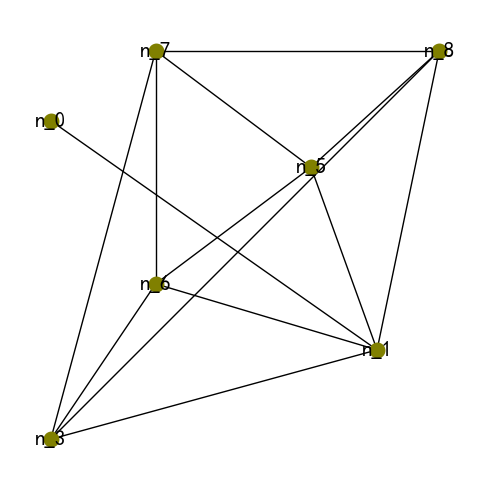

In [377]:
coords=list(partition(2,best_position))
pos=dict(zip(G.nodes, coords))
print(pos)
ann,_=usda_network.nni(coords,planning_area)    
print(ann)

usda_network.G_drawing(G,pos=pos,figsize=(5,5),node_size=20,font_size=15)

> 复杂网络更新实验是应用元启发式算法于复杂网络（图）的一次浅显探索，优化结果尚并不稳定

### 3.3.1.3 2维度布局优化——空间决策支持系统 

地理空间模式一般为2维度的研究（目前存在少数3维度上的探索），由受2维度影响的约束条件构建目标函数及其返回值（成本值），但更新的对象（例如权重向量）不再是1维向量，而是2维矩阵，那么初始化的权重矩阵则由2维度升级为3维度。遗传算法是较容易由1维度跨到2维度的一种元启发式算法，染色体（chromosome）为2维度，由染色体构建的种群（population）为3纬度。就栅格数据而言，构成染色体的基因（gene）为每个栅格单元的某一属性值，例如土地利用、土地覆盖、空气质量、温湿度、经济统计指标、生态各类因子，或衍生及综合指数等，这就为地理空间模式的探索应用元启发式算法提供了可能。

对于空间规划（2纬度地理空间模式探索），为一种资源分配（resource allocation）问题，称为空间决策支持系统（spatial decision support system，SDSS），支持寻找土地利用的最佳空间分布，通常包含多准则决策（MCDM）技术，评估可用的替代解决方案，且此类问题通常为高度非线性（nonlinear），涉及大量数据和大相径庭的目标（objectives）。2000年左右就出现大量 SDSS 协助决策者解决此类问题<sup>[Aerts, J. C. J. H. & Heuvelink, G. B. M. Using simulated annealing for resource allocation. International Journal of Geographical Information Science 16, 571–587 (2002).][Carver, S., Evans, A., Kingston, R. & Turton, I. Public participation, GIS, and cyberdemocracy: Evaluating on-line spatial decision support systems. Environ Plann B Plann Des 28, 907–921 (2001).][Pettit, C. J. Use of a collaborative GIS-based planning-support system to assist in formulating a sustainable-development scenario for Hervey Bay, Australia. Environ Plann B Plann Des 32, 523–545 (2005).]</sup>。其中Stewart, T. <sup>[Stewart, T. J., Janssen, R. & Van Herwijnen, M. A genetic algorithm approach to multiobjective land use planning. Comput Oper Res 31, 2293–2313 (2004).]</sup>、Janssen, R.<sup>[Janssen, R., van Herwijnen, M., Stewart, T. J. & Aerts, J. C. J. H. Multiobjective decision support for land-use planning. Environ Plann B Plann Des 35, 740–756 (2008).]</sup>和Cao, K<sup>[Cao, K., Huang, B., Wang, S. & Lin, H. Sustainable land use optimization using Boundary-based Fast Genetic Algorithm. Comput Environ Urban Syst 36, 257–269 (2012).]</sup>在 SDSS 一脉相承，分别从方法提出（基于遗传算法），问题描述和公式构建，进一步系统化和实验验证，到遗传算法2维度上交叉与变异方式的改进，相对该领域类似的研究建立了更全面系统的方法体系，因此应用该体系阐释 SDSS，并基于 Python 再现实验。

#### 1）问题的数学描述和公式构建

为了理解公式描述，各个变量的定义字符和解释如下：

$r$ &nbsp;&nbsp;&nbsp; 栅格单元行索引（cell row index ），$r=1, \ldots ,R$；

$c$ &nbsp;&nbsp;&nbsp; 栅格单元列索引（cell column index），$c=1, \ldots ,C$；

$k$ &nbsp;&nbsp;&nbsp; 土地利用类型索引（land-use index），$k=1, \ldots ,K$；

$p$ &nbsp;&nbsp;&nbsp; （决策）准则目标索引（additive objective index），$p=1, \ldots ,P$；（在 additive objective 翻译上，协同*权重决策*一章的多准则决策法用词）

$q$ &nbsp;&nbsp;&nbsp; 空间目标索引（spatial objective index），$q=1, \ldots ,Q$；

$U_{rc}$ &nbsp;&nbsp;&nbsp; 第$r$行，第$c$列栅格单元的土地利用类型（specific land use for cell ($r,c$)）；

$\boldsymbol{u}$ &nbsp;&nbsp;&nbsp; 所有栅格单元土地利用类型分配的矢量表示（即，所有行$r$和列$c$的$U_{rc}$）（vector representation of land-use allocation for all cells（i.e. $U_{rc}$ for all $r$ and $c$））；

$\chi_{r c k}$  &nbsp;&nbsp;&nbsp; 二元决策变量，指示栅格单元$(r,c)$是否被分配有第$k$类土地利用类型（即，如果$U_{rc}=k$，则$\chi_{r c k}=1$，否则$\chi_{r c k}=0$）（ binary decision variable indicating whether cell $(r,c)$ is allocated to land use $k$ ）；

$N_k$  &nbsp;&nbsp;&nbsp; 分配有土地利用类型$k$的栅格单元总数（total number of cells to be allocated to land use $k$）；

$\lambda_k$ &nbsp;&nbsp;&nbsp; 分配有土地利用类型$k$的最小栅格单元数（minimum number of cells to be allocated to land use $k$）；

$\mu_k$ &nbsp;&nbsp;&nbsp; 分配有土地利用类型$k$的最大栅格单元数（maximum number of cells to be allocated to land use $k$）；

$\mathrm{f}_p(\boldsymbol{u}), \mathrm{g}_{k q}(\boldsymbol{u})$ &nbsp;&nbsp;&nbsp; 分别为准则目标和空间目标函数的公式表述（formal representation additive and spatial objectives respectively）；

$a_{r c k p}$ &nbsp;&nbsp;&nbsp; 准则目标$p$的目标函数系数（objective function coefficient for additive objective $p$）;

$C_k$ &nbsp;&nbsp;&nbsp; 土地利用类型$k$的聚类（集聚）数量（ numbers of clusters for land use $k$）；

$L_k$ &nbsp;&nbsp;&nbsp;  土地利用类型$k$的最大聚类的相对大小（relative magnitude of the largest cluster for land use $k$）；

$R_k$ &nbsp;&nbsp;&nbsp; 土地利用类型$k$的紧密度（compactness of land use $k$）；

$I_p, I_{k q}$ &nbsp;&nbsp;&nbsp; 分别为准则目标和空间目标的理想值（ideal values for additive and spatial objectives respectively）；

$\gamma_p, \gamma_{k q}$ &nbsp;&nbsp;&nbsp; 分别为准则目标和空间目标的目标值（靶值）（ goal values for additive and spatial objectives respectively）；

$d_{l k}$ &nbsp;&nbsp;&nbsp; 将土地利用类型$l$转换为类型$k$的成本（ cost of changing land-use type $1$ into $k$）。

约束（constrains）条件包括3类，第1类为土地利用类型分配给各个栅格单元时的限制条件，例如一个栅格单元仅分配一种土地利用类型。或者特定的栅格单元仅允许某类土地利用类型存在等；第2类为准则目标（additive objective）的约束，例如每类土地利用类型的自然价值（收益/效益，benefits）、娱乐价值（收益）和一种土地类型转换为另一种类型的成本（成本，cost）等，成本或收益对应土地利用类型分配到各个栅格单元构成成本（收益）栅格（矩阵），总成本（收益）则为所有栅格单元之和，即累积相加（additively）;第3类为空间目标（spatial objective）的约束，例如各个土地利用类型在整个分析区域内的连通性、破碎化程度和紧密度等，通常与空间分布形态相关。

* 第1类约束——栅格数据的土地利用类型描述方法

分析区域为一个$R$行，$C$列的栅格，将第$k$个土地利用类型是否分配到各栅格单元$(r,c)$上时，存在两种情况，一种是分配，用值1表示；一种是不分配，用值0表示。即可以用一个二元决策变量$\chi_{r c k}$表示，将第$k$个土地利用类型分配给栅格单元$(r,c)$时有$\chi_{r c k}=1$；不分配则为$\chi_{r c k}=0$，且每一栅格单元仅分配有一类土地利用类型，不可重叠，因此有$\sum_{k=1}^K \chi_{r c k}=1, \quad \text { for } r=1, \ldots, R ; c=1, \ldots, C$，即对于同一栅格单元$(r,c)$，对所有土地利用类型索引$k$，只有一种土地利用类型值为$\chi_{r c k}=1$，其余均为$\chi_{r c k}=0$。、

因为为二元决策变量，因此分配有土地利用类型$k$的栅格单元总数为：$N_k=\sum_{r=1}^R \sum_{c=1}^C \chi_{r c k}$。每一种土地利用类型分布总面积（即具有第$k$类的土地利用类型栅格单元数）通常有限制，可表述为：$\lambda_k \leqslant N_k \leqslant \mu_k$，式中，$\lambda_k$为分配有土地利用类型$k$的最小栅格单元数；$\mu_k$ 为分配有土地利用类型$k$的最大栅格单元数。

*  第2类约束——决策目标

决策目标的约束可以表示为： $f_p(\boldsymbol{u})=\sum_{r=1}^R \sum_{c=1}^C \sum_{k=1}^K a_{r c k p} x_{r c k}$，式中$p$为（决策）准则目标索引；$\boldsymbol{u}$为所有栅格单元土地利用类型分配的矢量表示。准则目标可以为成本，也可以为收益，为统一成本（最小化）和收益（最大化）的方向，统一按成本最小化计算，因此收益最大化需要转换方向，一种方式是对系数$a_{r c k p}$增加符号取反值；或者用收益的理想最大值减收益值。

* 第3类约束——空间目标

空间目标约束类型根据决策目的的差异会发生变化，一般而言包括三种：

1. 最小化每类土地利用类型的聚类数量，用$C_k$表示。$C_k$衡量了土地利用的碎片化程度，最小化$C_k$，就是确保同类土地利用类型的栅格单元最大限度地连接在一起；
2. 最大化每类土地利用类型最大聚类地相对大小，用$L_k$表示。如果$C_k>1$，表明同一土地利用类型在地理空间分布上有多个聚类簇，最好使得其中一块簇的大小（连续栅格单元数量）占绝对优势，其它聚类簇尽量小；
3. 最大化每类土地利用类型的紧密度（compactness），用$R_k$表示。$R_k$通常定义为同一土地利用类型各聚类簇的周长（簇的沿边单元数）与簇大小（簇内所有单元数）的比值。

空间目标通常是高度非线性的，无法用封闭的数学形式（closed mathematical form）定义为$\chi_{r c k}$的函数。 因此定义空间目标函数为$\mathrm{g}_{k q}(\boldsymbol{u})$，并统一约束方向为最小化，对于$L_k$和$R_k$需要取反值。

对于决策目标和空间目标的约束描述为最小化$P+KQ$成本（靶值）的多目标优化问题，目标组合形式简单表示为：$\sum_{p=1}^P w_p \mathrm{f}_p(\boldsymbol{u})+\sum_{k=1}^K \sum_{q=1}^3 w_{k q} \mathrm{~g}_{k q}(\boldsymbol{u})$。简单的加法形式可能会导致具有极端倾向的高度偏差结果（一些目标得到很好的满足，而另一些则表现得很差），而不是平衡的妥协（balanced compromises ）。为了寻找更好的平衡妥协， 采用参考点（reference-point）（广义目标规划（generalized goal-programming））方法，涉及的关键点有：

1. 为每个目标指定理想值$I_p$或$I_{k q}$，分别表示目标函数$\mathrm{f}_p(\boldsymbol{u})$或$\mathrm{g}_{k q}(\boldsymbol{u})$实际上可以接受的最小可能值。某些情况，理想值可以直接计算，但有些情况需要启发式的评估；
2. 为每个目标指定靶值（目标值）$\gamma_p>I_p$或$\gamma_{k q}>I_{k q}$，表示可以归类为满意的表现水平，是对决策者的偏好进行建模的主要手段。该值通常并不是直接给出，而是通过给定理想值（ideal-value)和最差值（worst-value)，再给一个[0,1]的比率（nominal priority levels），获取理想值和最差值之间的一个值；
3. 通过最小化聚合函数（aggregate（scalarizing） function）：$\sigma(\boldsymbol{u})=\sum_{p=1}^P\left[\frac{\mathrm{f}_p(\boldsymbol{u})-I_p}{\gamma_p-I_p}\right]^4+\sum_{k=1}^K \sum_{q=1}^3\left[\frac{\mathrm{g}_{k q}(\boldsymbol{u})-I_{k q}}{\gamma_{k q}-I_{k q}}\right]^4$，尽可能接近指定的靶值。如果$\mathrm{f}_p(\boldsymbol{u}), \mathrm{g}_{k q}(\boldsymbol{u})$远离靶值$\gamma_p, \gamma_{k q}$，对应的惩罚项（指数）会使得成本值快速增大，因此$\sigma(\boldsymbol{u})$避免了非常差的表现结果出现，从而产生平衡的妥协。

最小化聚合函数采取元启发式算法，该实验选择的为遗传算法。

#### 2）用Python 再现实验

**A - 目标约束配置和构建目标函数**

实验数据以 Janssen, R 的 Jisperveld 土地利用规划为例，覆盖面积为400 ha。该区域为西欧最大咸水泥炭草甸地区的一部分，整个区域水网纵横交错，存在多种稀有草甸鸟类和一些特殊植被。处理后的土地利用数据为 20×20 的栅格数据，包括9种土地利用类型，集约化农业（intensive agriculture）、粗放式农业（extensive agriculture）、住宅（residence）、工业（industry）、娱乐休闲（日游）（recreation（day trips））、娱乐休闲（过夜）（recreation（overnight））、湿地（wet natural area）、水体（娱乐用）（water（recreational use））和水体（限制进入）（water（limited access））等。该区域要开发一个结合娱乐休闲和自然价值的项目，根据自然保护的要求，提出了3条准则目标约束，

1. 最大化该区域的自然价值；
2. 最大化该区域的娱乐价值；
2. 最小化土地利用类型转换的成本。

同时，确定3个与规划相关的空间目标约束，

1. 最小化碎片化；
2. 最大化最大聚类簇；
3. 最大化紧密度。

> 为了方便实验，该实验数据写入至`USDA`，通过`load_jisperveld_data()`方法调用。

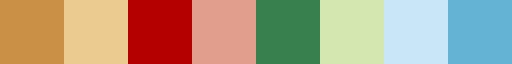

In [2]:
import matplotlib

lu_class_idNcolor={
    'intensive_agriculture':[1,"#ca9146"],
    'extensive_agriculture':[2,"#ebcb90"],
    'residence':[3,"#b50000"],
    'industrye':[4,"#e29e8c"],
    'recreation_day_tripsy':[5,"#38814e"],
    'recreation_overnight':[6,"#d4e7b0"],
    'wet_natural_area':[7,"#c8e6f8"],
    'water_recreational_use':[8,"#64b3d5"],
    'water_limited_access':[9,'#5475a8'],
    }
lu_class_color={v[0]:v[1] for v in lu_class_idNcolor.values()}
cmap_LC, norm=matplotlib.colors.from_levels_and_colors(list(lu_class_color.keys()),list(lu_class_color.values()),extend='max')
cmap_LC

{1: 'intensive_agriculture', 2: 'extensive_agriculture', 3: 'residence', 4: 'industry', 5: 'recreation_day_trips', 6: 'recreation_overnight', 7: 'wet_natural_area', 8: 'water_recreational_use', 9: 'water_limited_access'}


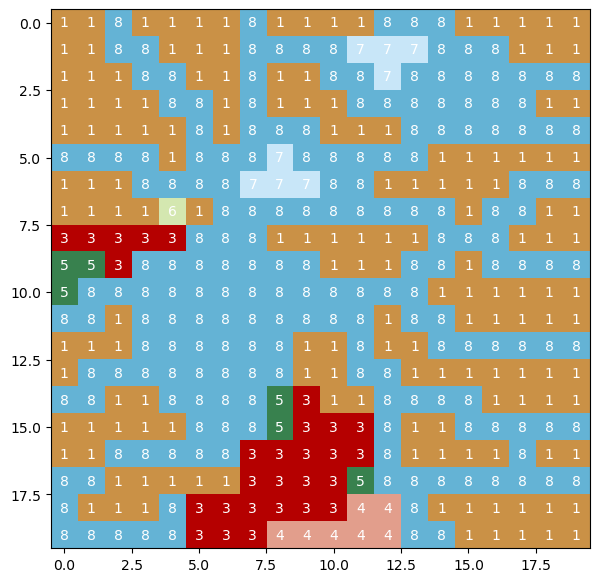

In [3]:
jisperveld_data=usda_datasets.load_jisperveld_data()
jisperveld_lu=jisperveld_data['lu']
jisperveld_lu_name=jisperveld_data['lu_name']
print(jisperveld_lu_name)
usda_vis.imshow_label2darray(jisperveld_lu,figsize=(7,7),cmap=cmap_LC,norm=norm,fontsize=10)

* 准则目标约束

准则目标约束有3个，自然价值、娱乐休闲价值和土地利用转换，所采取的计算方法都是各个单元（土地利用类型）对应价值的总和。对于自然价值和娱乐休闲价值给出不同土地利用类型对应的值，一种方式是固定的值；另一种方式是成本地图的形式。固定的值如下，包括两列，`nature_value`列用于自然价值计算；`nature_value`列用于娱乐休闲价值计算。如果对应的值为字符串，例如`nature_vals`、`recreation_b`和`recreation_c`，则为对应的成本地图，其值为所选土地利用类型所在位置对应的值。自然成本和娱乐休闲成本的公式可表述为：

$\begin{aligned} & \mathrm{f}_{\text {nature }}(\boldsymbol{u})=\sum_{r=1}^{20} \sum_{c=1}^{20} \sum_{k=1}^9 a_{r c k(\text { nature })} \chi_{r c k}  \\ & \mathrm{f}_{\text {recreation }}(\boldsymbol{u})=\sum_{r=1}^{20} \sum_{c=1}^{20} \sum_{k=1}^9 a_{r c k \text { (recreation })} \chi_{r c k} \end{aligned}$

In [77]:
jisperveld_data['nature_recreation_vals']  

,nature_value,recreational_value
intensive_agriculture,4,6
extensive_agriculture,nature_vals,nature_vals
residence,3,3
industry,1,1
recreation_day_trips,5,recreation_b
recreation_overnight,5,recreation_c
wet_natural_area,nature_vals,7
water_recreational_use,7,recreation_b
water_limited_access,nature_vals,1


`nature_vals`价值地图，为土地利用类型对草甸鸟类的价值，例如工业和住区对鸟类的干扰，其值较低，而粗放式农业、湿地和限制性水域具有较高的值。

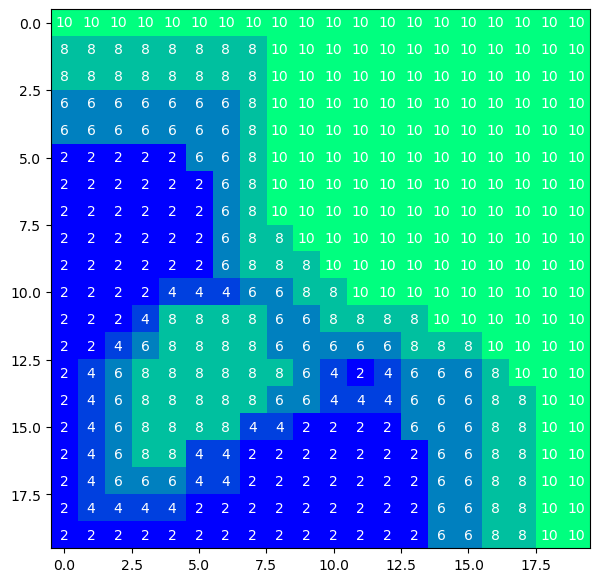

In [34]:
usda_vis.imshow_label2darray(jisperveld_data['nature_vals'],figsize=(7,7),cmap='winter',fontsize=10)

`recreation_b`价值地图，反映了水域的价值。

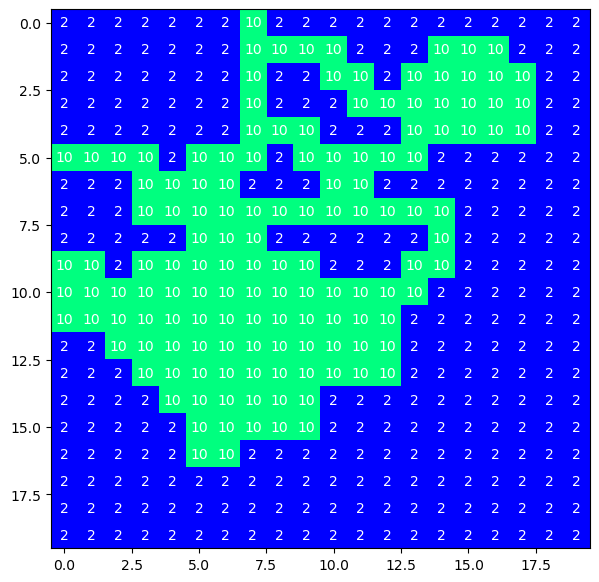

In [35]:
usda_vis.imshow_label2darray(jisperveld_data['recreation_b'],figsize=(7,7),cmap='winter',fontsize=10)

`recreation_c`价值地图，反映了水域边缘的价值。

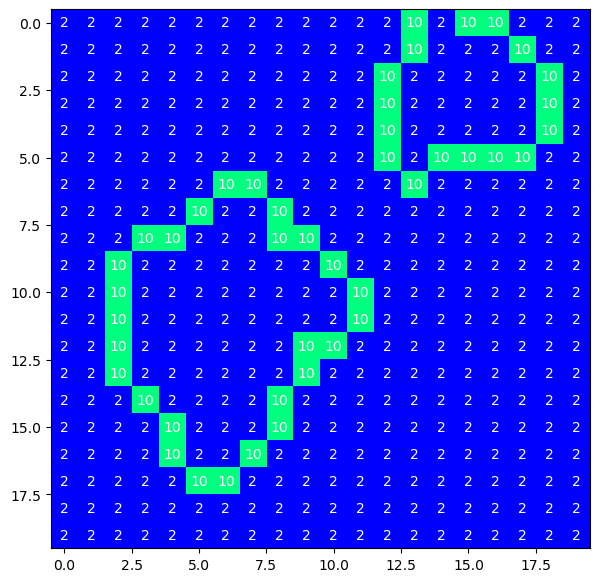

In [36]:
usda_vis.imshow_label2darray(jisperveld_data['recreation_c'],figsize=(7,7),cmap='winter',fontsize=10)

土地利用转换成本是根据土地使用类型从一种转换为另一种导致的土地价值变化和转换相关措置（例如，管理成本，土壤转换为水的土方量等）的成本计算。如下表，空值为不能转换的类型，单位为欧元。土地利用类型转换成本公式表述为：$ \mathrm{f}_{\text {cost }}(\boldsymbol{u})=\sum_{r=1}^{20} \sum_{c=1}^{20} \sum_{k=1}^9 a_{r c k(\text { cost })} \chi_{r c k} $。

In [81]:
jisperveld_data['lu_conversion_cost']

,intensive_agriculture,extensive_agriculture,residence,industry,recreation_day_trips,recreation_overnight,wet_natural_area,water_recreational_use,water_limited_access
intensive_agriculture,0.0,-75.0,150.0,150.0,-225.0,0.0,-150.0,-300.0,-300.0
extensive_agriculture,75.0,0.0,150.0,150.0,-150.0,75.0,-75.0,-225.0,-225.0
residence,NaN,NaN,0.0,NaN,-10000.0,-10000.0,NaN,NaN,NaN
industry,NaN,NaN,NaN,0.0,-10000.0,-10000.0,NaN,NaN,NaN
recreation_day_trips,150.0,75.0,3.0,300.0,0.0,150.0,0.0,-150.0,-150.0
recreation_overnight,0.0,-75.0,150.0,150.0,-150.0,0.0,-150.0,-300.0,-230.0
wet_natural_area,NaN,75.0,225.0,225.0,-75.0,150.0,0.0,-75.0,-75.0
water_recreational_use,100.0,100.0,NaN,NaN,NaN,NaN,0.0,0.0,15.0
water_limited_access,100.0,100.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


定义`target_function_additive_objectives_constrains()`目标函数，实现准则目标成本（收益）值的计算。

In [77]:
def target_function_additive_objectives_constrains(lus):
    global jisperveld_data        
    
    nature_recreation_vals=jisperveld_data['nature_recreation_vals']    
    lu_name=jisperveld_data['lu_name']
    nature_vals_lst=[]
    recreation_vals_lst=[]    
    
    for k,v in lu_name.items():        
        lu_mask=lus==k
        
        # natural cost
        nature_val=nature_recreation_vals['nature_value'][v]        
        if type(nature_val)==str:
            nature_vals_map=jisperveld_data[nature_val]
            lu_nature_val=nature_vals_map*lu_mask   
        else:
            lu_nature_val=lu_mask*nature_val
  
        nature_vals_lst.append(lu_nature_val)
        
        # recreational cost
        recreation_val=nature_recreation_vals['recreational_value'][v]  
        if type(recreation_val)==str:
            recreation_vals_map=jisperveld_data[recreation_val]
            lu_recreation_val=recreation_vals_map*lu_mask   
        else:
            lu_recreation_val=lu_mask*recreation_val
            
        recreation_vals_lst.append(lu_recreation_val)    
        
    # lu conversion cost
    lus_original=jisperveld_data['lu']
    changed_mask=~((lus-lus_original)==0)
    original=lus_original[changed_mask]
    changed=lus[changed_mask]
    original2changed=list(zip(original,changed))
    
    conversion_cost_matrix=jisperveld_data['lu_conversion_cost'].T
    conversion_cost_matrix.fillna(9999999999,inplace=True) # 对空值进行替换
    
    conversion_cost=0
    for pair in original2changed:
        conversion_pair_cost=jisperveld_data['lu_conversion_cost'].T[lu_name[pair[0]]][lu_name[pair[1]]]
        conversion_cost+=conversion_pair_cost           
    
    nature_costs=np.array(nature_vals_lst).sum(axis=0)
    recreation_costs=np.array(recreation_vals_lst).sum(axis=0)
    
    nature_cost=nature_costs.sum()
    recreation_cost=recreation_costs.sum()
    
    return nature_cost,recreation_cost,conversion_cost

jisperveld_lu_changed=jisperveld_lu+(jisperveld_lu==3)*3 # 测试用假设已变化的土地利用类型
nature_cost,recreation_cost,conversion_cost=target_function_additive_objectives_constrains(jisperveld_lu_changed)
print(nature_cost,recreation_cost,conversion_cost)

2239 2493 -280000.0


* 空间目标约束

空间目标约束有3个，为碎片化、最大簇比率和紧密度。碎片化的计算是使用`components-3d`库`connected_components`方法计算连通域标签，获得具有同一土地利用类型所有簇的数量。最大簇比率是由连通域标签得出同一土地利用类型的所有簇大小，由最大值除以所有属于该土地利用类型的栅格单元数获得。紧密度计算方法做了调整，按一个基因与邻里8个基因对形成不同组合的数量除以8的方式，求和所有不同组合基因对并除以栅格总数。

定义`target_function_spatial_objectives_constrains()`函数，实现空间目标成本（收益）值计算。

In [59]:
def target_function_spatial_objectives_constrains(lus):        
    #  minimize fragmentation
    clump_2darray,C=cc3d.connected_components(lus,connectivity=8,return_N=True,out_dtype=np.uint64) 
   
    # maximize the largest cluster
    unique, counts=np.unique(clump_2darray, return_counts=True)
    unique_counts=dict(zip(unique, counts))
    class_clump=np.stack((lus,clump_2darray),axis=2)
    class_clump_mapping=usda_signature.lexsort_based(class_clump.reshape(-1,2)).tolist()
    class_clump_mapping.sort(key=lambda x:x[0])
    class_clump_max=[[int(i[0]),unique_counts[i[1]]] for i in class_clump_mapping]
    cluster_num_dict=defaultdict(list)    
    for k,v in class_clump_max:
        cluster_num_dict[k].append(v)
    L_k={k:max(v)/sum(v) for k,v in cluster_num_dict.items()}
    L=sum(L_k.values())

    #  maximize compactness
    xextent,yextent=lus.shape
    ngh_finder=usda_signature.GridNghFinder(0, 0, xextent-1,yextent-1)
    x_=np.linspace(0, xextent-1, xextent)
    y_=np.linspace(0, yextent-1, yextent)
    x_idx, y_idx=np.meshgrid(x_, y_) 
    xy=np.stack((x_idx,y_idx),axis=2).reshape(-1,2).astype(int)
    pairs=np.empty((0,2),int)
    R=0
    for i in xy:
        nghs=ngh_finder.find(i[0],i[1])
        ngh_vals=[lus[j[0],j[1]] for j in nghs]
        i_val=lus[i[0],i[1]]
        ngh_vals.remove(i_val)
        i_pairs=np.array([[i_val,k] for k in ngh_vals])
        i_pairs_set=set(list(zip(i_pairs.T[0],i_pairs.T[1])))     
        pairs_num_fraction=len(i_pairs_set)/8
        R+=pairs_num_fraction/400
    
    return C,L,R
    
C,L,R=target_function_spatial_objectives_constrains(jisperveld_lu)    
print(C,L,R)

29 4.893994540491356 0.26937499999999776


* 土地利用类型的面积（栅格单元数）控制约束

规格过程中通常要限制各类土地利用类型的面积，其成本值的计算方式为：$\frac{ \mid max\{max\{0;\lambda_k-N_k\},max\{N_k-\mu_k\}\} \mid }{\beta_k} $，式中，$N_k$ 为分配有土地利用类型$k$的栅格单元总数；$\lambda_k$为分配有土地利用类型$k$的最小栅格单元数；$\mu_k$为分配有土地利用类型$k$的最大栅格单元数； $\beta_k$为比例因子，本实验配置为栅格总数$RC$。如果土地利用类型栅格单元数位于给定区间，则返回成本值为0；如果小于$\lambda_k$或者大于$\mu_k$，则返回到$\lambda_k$或者$\mu_k$的距离值，并除以栅格总数。这使得土地利用类型栅格单元数或多或少的在指定区间内，而不是趋向于一个具体的值，为趋向于不精确的确定。

定义`target_function_lu_area()`函数实现土地利用类型的面积约束成本计算。

In [102]:
def target_function_lu_area(lus):
    global domain_lu_area,jisperveld_data   
    
    lu_name=jisperveld_data['lu_name']
    lu_idx2name={v:k for k,v in lu_name.items()}
    domain_lu_area_idx={lu_idx2name[k]:v for k,v in domain_lu_area.items()}
    unique, counts=np.unique(lus, return_counts=True)
    unique_counts=dict(zip(unique, counts))
    
    minimumBound_onClusterSize=1
    p=4
    
    cost=0
    for idx,count in unique_counts.items():     
        domain=domain_lu_area_idx[idx]
        dis=max([max(0,domain[0]-count),max(0,count-domain[1])])
        dis_abs_fraction=abs(dis)/minimumBound_onClusterSize # lus.size
        cost+=pow(dis_abs_fraction,p)        
        
    return cost

domain_lu_area={'intensive_agriculture':[80,150],
                'extensive_agriculture':[20,65],
                'residence':[20,45], 
                'industry':[5,15], 
                'recreation_day_trips':[0,70], 
                'recreation_overnight':[0,35],
                'wet_natural_area':[0,30],
                'water_recreational_use':[120,150],
                'water_limited_access':[0,60]}
    
lu_area_cost=target_function_lu_area(jisperveld_lu)
print(lu_area_cost)

3421202.0


* 构建聚合目标函数

上述计算了三大类约束，准则目标约束（含3小类）、空间目标约束（含3小类）和土地利用类型的面积约束。各小类约束的成本值区间范围不同，约束方向不同，通过采用前文阐释的参考点（reference-point）方法，可以标准化数值和方向，定义`domain_objectives_worst2best`变量存储各类约束的最小值和最大值（理想值），靶值的比率由参数`priority_level`调整，实验中配置值为0.5，即取最小值和最大值的中间值作为靶值$\gamma_p,\gamma_{k q}$。土地利用类型的面积约束不使用参考点的方法，直接使用*土地利用类型的面积（栅格单元数）控制约束*部分的计算公式。

对各类约束成本区间范围的指定，可以根据约束条件推断得出，例如自然成本区间`natrue_cost`和娱乐休闲成本区间`recreation_cost`根据前文给出的自然价值、娱乐休闲价值表推断，最小价值为1，最大价值为10，栅格总数为400，因此区间为[400,4000]；对于土地利用转换的成本区间`lu_conversion_cost`根据前文土地利用类型转换成本表推断，用转换成本最小值（-10000）和最大值（300）乘以栅格总数；对于最小化每类土地利用类型的聚类数量成本区间`C`，因为总共有9类土地利用类型，如果每类只有一个簇，则为9，假设各为5个，则有45个，因此估计区间为[45,9]；对于最大化每类土地利用类型最大聚类地相对大小区间`L`，一类土地类型只有1个簇的情况值为1，因此最大值为9，假设最大簇比率比率为0.2，则区间为[1.8,9]；对于最大化每类土地利用类型的紧密度区间`R`，自身值域为[0,1]。

In [70]:
def target_function_jisperveld_plan(lus):
    global domain_objectives_worst2best,cost_filter

    nature_cost,recreation_cost,conversion_cost=target_function_additive_objectives_constrains(lus)
    C,L,R=target_function_spatial_objectives_constrains(lus)       
    cost_dict_={'natrue_cost':nature_cost,'recreation_cost':recreation_cost,'lu_conversion_cost':conversion_cost,'C':C,'L':L,'R':R,'lu_area_cost':None}     
    cost_dict={k:v for k,v in cost_dict_.items() if k in cost_filter}   
        
    p=4    
    cost=0    
    
    def reference_pt(k,priority_level):            
            domain=domain_objectives_worst2best[k]        
            target_val=(domain[1]-domain[0])*priority_level+domain[0]
            g_v=(v-domain[1])/(target_val-domain[1])
            g_v_power=pow(g_v,p)
            
            return g_v_power
            
    for k,v in cost_dict.items():
        if k=='lu_area_cost':
            lu_area_cost=target_function_lu_area(lus)    
            cost+=lu_area_cost        
        elif k in ['natrue_cost','recreation_cost','lu_conversion_cost']:
            g_v_power=reference_pt(k,0.5)
            cost+=g_v_power
        elif k in ['C','L','R']:
            g_v_power=reference_pt(k,0.5)
            cost+=g_v_power           

    return cost    
    
domain_objectives_worst2best={'natrue_cost':[1*400,10*400],'recreation_cost':[1*400,10*400],'lu_conversion_cost':[300*400,-10000*400],'C':[5*9,1*9],'L':[0.2*9,1*9],'R':[1,0]}    
cost_filter=['natrue_cost','recreation_cost','lu_conversion_cost','C','L','R','lu_area_cost']
cost=target_function_jisperveld_plan(jisperveld_lu_changed)
print(cost)

17.62373549948494


* 固定栅格单元的土地利用类型

更新规划中会存在不可变动的土地利用类型区域（栅格单元），也可以为预先定义的栅格单元土地利用类型，来排除不可能或不能接受的土地利用类型转换。下图显示了固定栅格的土地利用类型分布。固定栅格单元的土地利用类型不作为约束传入目标函数，需要在遗传算法过程中加入该条件，在初始化种群，交叉和变异染色体后都需要用该条件置换对应栅格的土地利用类型。

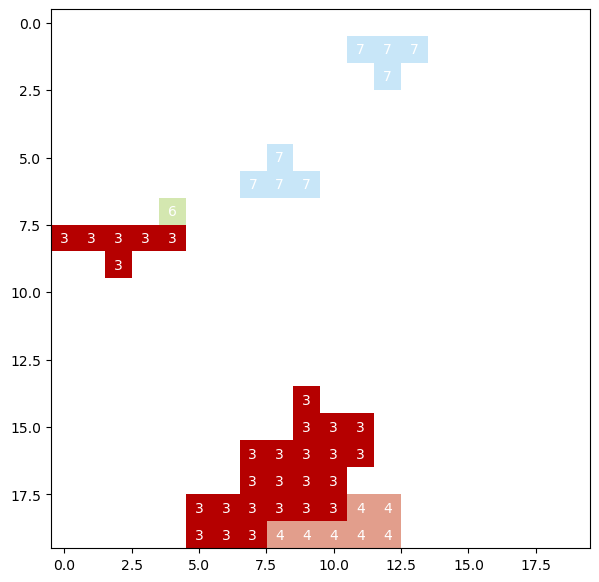

In [37]:
usda_vis.imshow_label2darray(jisperveld_data['fixed_LU'],figsize=(7,7),cmap=cmap_LC,norm=norm,fontsize=10)

**B - 2维度染色体的交叉和变异**

遗传算法基本的交叉和变异（1维度）如下图A<sup>[+]</sup>所示。交叉是随机获取一个交叉点，将父代（2个染色体）按照交叉点互换生成子代。变异则是随机从染色体中提取一个基因，通常按基因变化的幅度（“权重”值变化的幅度）增减值。

当染色体从1维到2维，交叉和变异的算法样式较为丰富，通常需要根据优化对象采取适宜的方式。下图B<sup>[Tsai, M. W., Hong, T. P. & Lin, W. T. A two-dimensional genetic algorithm and its application to aircraft scheduling problem. Math Probl Eng 2015, (2015).]</sup>为一个2维染色体较为简单的变化，其交叉是根据随机交叉点水平或垂直置换父代2个染色体对应位置的基因。变异则是随机提取一个基因，将其与其余的一个随机基因置换；或者随机行或列的置换。此类2维度染色体的变异和交叉并未体现空间属性，例如土地利用或土地覆盖类型通常具有集聚的特点等，因此对具有空间属性的数据寻找最优解时，执行此类交叉和变异的方法通常很难达到预期结果。但是此类算法可解决不具有空间属性的问题，例如将飞机分配到时间表的调度问题，矩阵的横轴为时间，纵轴为可用飞机序号，不同架飞机的飞行任务需要被排入时间表中，约束条件有周转时间约束，连续飞行的抵达和飞离的位置应形同，及餐饮和燃料成本等。

为了能够优化多目标约束的土地利用分配等问题，使2维度染色体的交叉和变异时考虑到增加空间的连接度、紧密度、单类最大簇相对大小和减小碎片化等问题，Cao, K等提出了基于边界的交叉算子（ Boundary-based Crossover Operator，CBO）和基于补丁的变异算子（Patch-based Mutation Operator，MPO），及基于边界的变异算子（Boundary-based Muta- tion Operator，MBO），如下图C<sup>[+]</sup>。CBO交叉的方法是，对于从父代2个染色体随机提取的基因R1和R2（位置同），如果两个基因不同（即土地利用类型不同），且R1的邻里8个单元中有与R2相同的基因，则将R1置换为R2。如果随机提取的同一位置的R1和R2基因相同，则继续寻找，直至找到不同的位置进行交叉。该方法增加了相同基因的集聚可能。MPO变异的方法是，构建一个变异窗口，即从9个方形单元格中随机选择7个连续的单元格，并随机选择一种基因。然后从染色体中随机选择变异位置，例如R2基因，将其对应变异窗口位置的基因进行基因替换。MBO变异基本同MPO变异，只是从染色体中随机提取的基因R2的8个邻里单元中需要有同变异窗口相同的基因才执行变异操作。上述变异的方式同样增加了同一基因集聚的可能，并将原染色体可能破碎的区域替换为同类基因连续的团块。

<img src="../imgs/3_3/3_3_02.jpg" height='auto' width='auto' title="caDesign">

将不同方法的交叉和变异增加到遗传算法`genetic_algorithm_2d_fixed_map`程序中，通过参数`crossover_name`调整交叉算法（例如，`crossover_CBO`、`crossover_tsai`等）；通过参数`mutation_nam`调整变异算法（例如，`mutation_MPO_MBO`（配合参数`mpo_mbo`）、`mutation_tsai_2`和`mutation_tsai_1`等）。

> 程序中算法的命名部分以作者定义的算法名称组成，部分为作者的姓名组成

**C - 寻找多目标空间规划的最优解**

完成约束的定义，目标函数的定义，并增加了部分交叉和变异算法，试图寻找多目标空间规划的最优解。元启发式算法通常需要不断地调试参数值，甚至调整选择、交叉和变异的算法，才能够较好的拟合，获取可以参考的最优解，这对于解算非线性的空间问题尤其突出。初始化种群时，一般为完全随机生成，通过寻找成本值趋近于0（最小化）适合的染色体，找到最优解。对于已有现状条件的土地利用，也尝试初始化的种群为现状条件，在已有基础上进行扰动寻找最优解，配置的参数为`population_init`。

为了检验约束设计及其遗传算法收敛情况，首先进行了单目标的测试。

1. 最小化碎片化检验

最小化碎片化是计算连通域标签，获得总共簇的数量，并尽量使得该值最小。通过下述计算，对于一个随机生成的种群（50个染色体），经过1000次的迭代，迭代的最优解得以下降，最后最优解的连通域簇数量为63，表明通过连通域计算簇数的方法对于降低碎片化可行，如果继续迭代，该值可能继续下降。

Generation = 0;	 f(x) = 24414.0625
Generation = 100;	 f(x) = 653.2441796220087
Generation = 200;	 f(x) = 215.92669753086423
Generation = 300;	 f(x) = 140.75918305136415
Generation = 400;	 f(x) = 115.42982205456484
Generation = 500;	 f(x) = 115.42982205456484
Generation = 600;	 f(x) = 115.42982205456484
Generation = 700;	 f(x) = 115.42982205456484
Generation = 800;	 f(x) = 115.42982205456484
Generation = 900;	 f(x) = 81.0


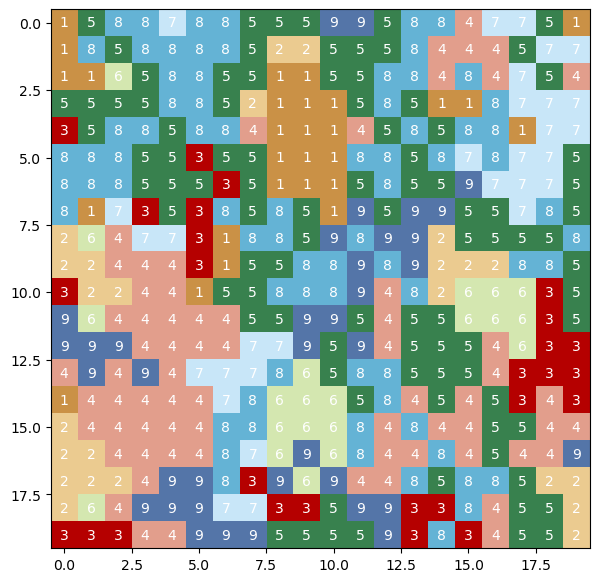

In [32]:
#cost_dict={'natrue_cost':nature_cost,'recreation_cost':recreation_cost,'lu_conversion_cost':conversion_cost,'C':C,'L':L,'R':R} 
cost_filter=['C']
objects_idx=list(range(1,10))
rows_n=20
cols_n=20  
fixed_map=jisperveld_data['fixed_LU']

domain_lu_area={'intensive_agriculture':[80,150],
                'extensive_agriculture':[20,65],
                'residence':[20,45], 
                'industry':[5,15], 
                'recreation_day_trips':[0,70], 
                'recreation_overnight':[0,35],
                'wet_natural_area':[0,30],
                'water_recreational_use':[120,150],
                'water_limited_access':[0,60]}

domain_objectives_worst2best={'natrue_cost':[1*400,10*400],'recreation_cost':[1*400,10*400],'lu_conversion_cost':[300*400,-10000*400],'C':[5*9,1*9],'L':[0.2*9,1*9],'R':[1,0]}    

pattern_generated_random_C,epoch=usda_heuristicsw.genetic_algorithm_2d_fixed_map(
        objects_idx,
        rows_n=rows_n,
        cols_n=cols_n,
        population_size=50,
        generations=1000,
        mutation_rate=0.5,
        target_function=target_function_jisperveld_plan,
        crossover_name='crossover_CBO',
        mutation_name='mutation_MPO_MBO', 
        mpo_mbo='mpo', 
        verbose=100)
usda_vis.imshow_label2darray(pattern_generated_random_C,figsize=(7,7),cmap=cmap_LC,norm=norm,fontsize=10)

63


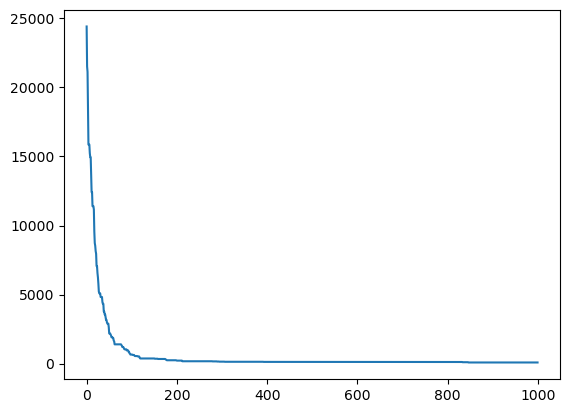

In [36]:
C,_,_=target_function_spatial_objectives_constrains(pattern_generated_random_C)    
print(C)

fig, ax=plt.subplots()
ax.plot(epoch.keys(),epoch.values())
plt.show()

2. 最大化最大聚类簇

最大化最大聚类簇是各土地利用类型最大簇与该类所有栅格单元的比值。随机初始化的种群，迭代1000次，成本值稳步下降，表明该空间目标可以增大单个土地利用类型的最大簇相对大小。

Generation = 0;	 f(x) = 21.3395847255005
Generation = 100;	 f(x) = 7.715728408488455
Generation = 200;	 f(x) = 2.930991796196175
Generation = 300;	 f(x) = 2.502192278872799
Generation = 400;	 f(x) = 2.095008764627904
Generation = 500;	 f(x) = 1.926847709156549
Generation = 600;	 f(x) = 1.9143194758101802
Generation = 700;	 f(x) = 1.9143194758101802
Generation = 800;	 f(x) = 1.9143194758101802
Generation = 900;	 f(x) = 1.9143194758101802


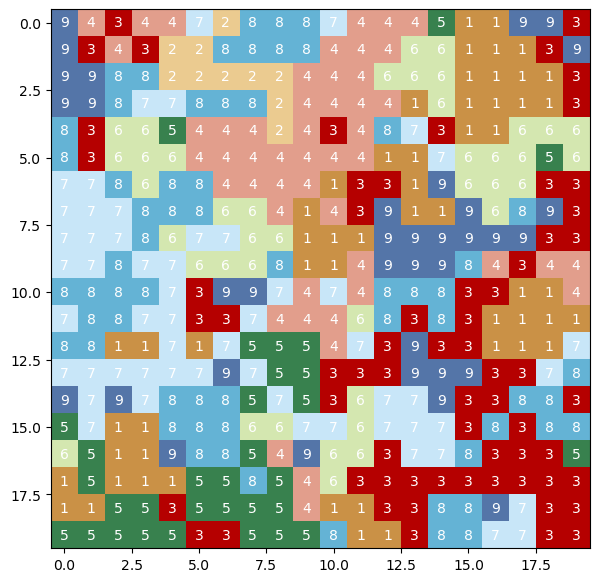

In [39]:
cost_filter=['L']

pattern_generated_random_L,epoch=usda_heuristicsw.genetic_algorithm_2d_fixed_map(
        objects_idx,
        rows_n=rows_n,
        cols_n=cols_n,
        population_size=50,
        generations=1000,
        mutation_rate=0.5,
        target_function=target_function_jisperveld_plan,
        crossover_name='crossover_CBO',
        mutation_name='mutation_MPO_MBO', 
        mpo_mbo='mpo',
        verbose=100)
usda_vis.imshow_label2darray(pattern_generated_random_L,figsize=(7,7),cmap=cmap_LC,norm=norm,fontsize=10)

4.765461310579871


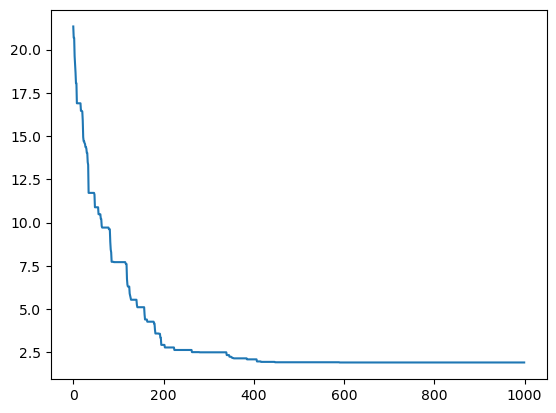

In [42]:
_,L,_=target_function_spatial_objectives_constrains(pattern_generated_random_L)    
print(L)

fig, ax=plt.subplots()
ax.plot(epoch.keys(),epoch.values())
plt.show()

3. 最大化紧密度

通过检验，迭代1000次，成本值不断下降，表明最小化基因与邻里8个基因对形成不同组合的数量的方法可以增加基因的紧密度。

Generation = 0;	 f(x) = 2.6117034558618255
Generation = 100;	 f(x) = 0.6434352223390067
Generation = 200;	 f(x) = 0.561460441684709
Generation = 300;	 f(x) = 0.45766070628905064
Generation = 400;	 f(x) = 0.4535017567384239
Generation = 500;	 f(x) = 0.4535017567384239
Generation = 600;	 f(x) = 0.4480006618287534
Generation = 700;	 f(x) = 0.4480006618287534
Generation = 800;	 f(x) = 0.4480006618287534
Generation = 900;	 f(x) = 0.4480006618287534


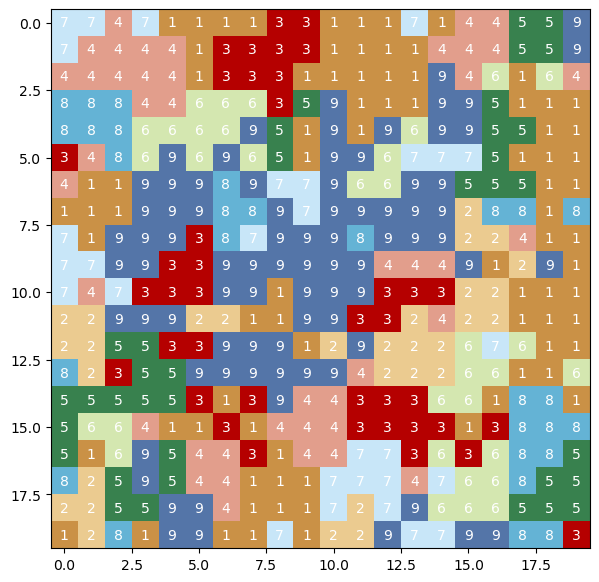

In [71]:
cost_filter=['R']

pattern_generated_random_R,epoch=usda_heuristicsw.genetic_algorithm_2d_fixed_map(
        objects_idx,
        rows_n=rows_n,
        cols_n=cols_n,
        population_size=50,
        generations=1000,
        mutation_rate=0.5,
        target_function=target_function_jisperveld_plan,
        crossover_name='crossover_CBO',
        mutation_name='mutation_MPO_MBO', 
        mpo_mbo='mpo',
        verbose=100)
usda_vis.imshow_label2darray(pattern_generated_random_R,figsize=(7,7),cmap=cmap_LC,norm=norm,fontsize=10)

0.40906249999999716


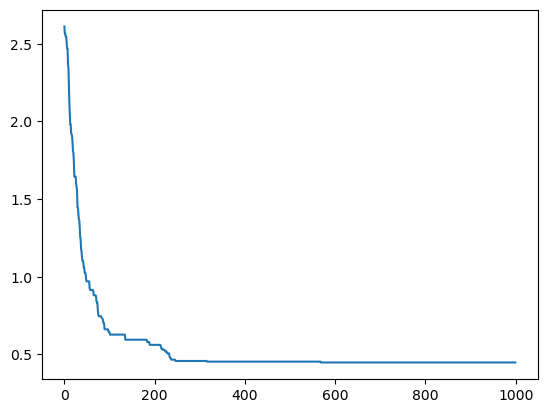

In [72]:
_,L_,R=target_function_spatial_objectives_constrains(pattern_generated_random_R)    
print(R)

fig, ax=plt.subplots()
ax.plot(epoch.keys(),epoch.values())
plt.show()

4. 准则目标约束检测

对3个准则目标同时进行检测。随迭代的增加，成本值能够持续下降，表明前文对准则目标的约束配置是适合的。

Generation = 0;	 f(x) = 3.808062600912729e+22
Generation = 10;	 f(x) = 2.5106993425899837e+22
Generation = 20;	 f(x) = 2.3904481649399735e+22
Generation = 30;	 f(x) = 1.952102317623157e+22
Generation = 40;	 f(x) = 1.7570537172036949e+22
Generation = 50;	 f(x) = 1.1190267994338828e+22
Generation = 60;	 f(x) = 1.0537004297430581e+22
Generation = 70;	 f(x) = 1.0537002757759955e+22
Generation = 80;	 f(x) = 9.316688413940868e+21
Generation = 90;	 f(x) = 8.205569806348615e+21


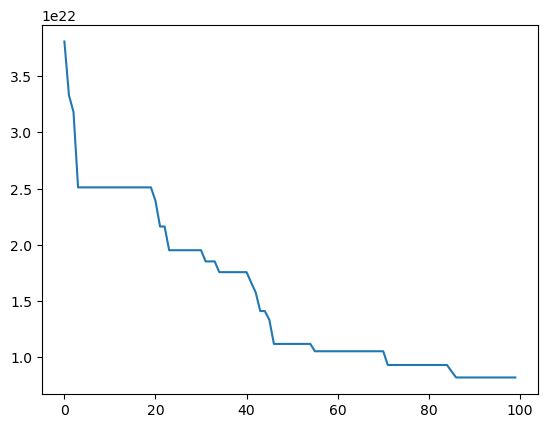

In [78]:
cost_filter=['natrue_cost','recreation_cost','lu_conversion_cost']

pattern_generated_random_additive,epoch=usda_heuristicsw.genetic_algorithm_2d_fixed_map(
        objects_idx,
        rows_n=rows_n,
        cols_n=cols_n,
        population_size=50,
        generations=100,
        mutation_rate=0.5,
        target_function=target_function_jisperveld_plan,
        crossover_name='crossover_CBO',
        mutation_name='mutation_MPO_MBO', 
        mpo_mbo='mpo',
        verbose=10)

fig, ax=plt.subplots()
ax.plot(epoch.keys(),epoch.values())
plt.show()

5. 土地利用面积约束检测

由下述计算结果，持续的成本值收敛，及各个土地利用类型数量统计（统计结果均位于初始配置区间内），可以初步判断，前文对土地利用面积区间约束的计算方法可以逐迭代的降低成本值，具有可行性。

Generation = 0;	 f(x) = 18385554.0
Generation = 20;	 f(x) = 10971234.0
Generation = 40;	 f(x) = 2758514.0
Generation = 60;	 f(x) = 122068.0
Generation = 80;	 f(x) = 9089.0


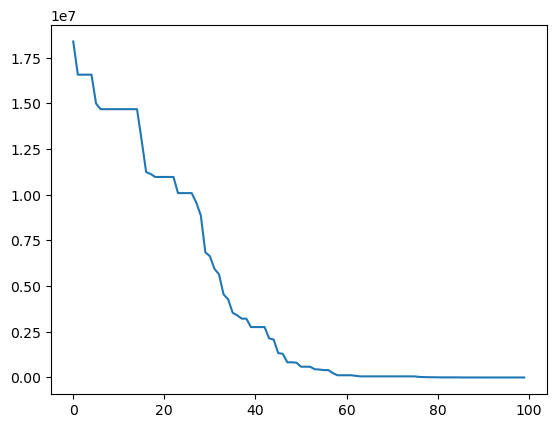

In [112]:
cost_filter=['lu_area_cost']

pattern_generated_random_lu_area,epoch=usda_heuristicsw.genetic_algorithm_2d_fixed_map(
        objects_idx,
        rows_n=rows_n,
        cols_n=cols_n,
        population_size=50,
        generations=100,
        mutation_rate=0.5,
        target_function=target_function_jisperveld_plan,
        crossover_name='crossover_CBO',
        mutation_name='mutation_MPO_MBO', 
        mpo_mbo='mpo',
        verbose=20)

fig, ax=plt.subplots()
ax.plot(epoch.keys(),epoch.values())
plt.show()

{1: 83, 2: 46, 3: 26, 4: 15, 5: 27, 6: 25, 7: 27, 8: 120, 9: 31}


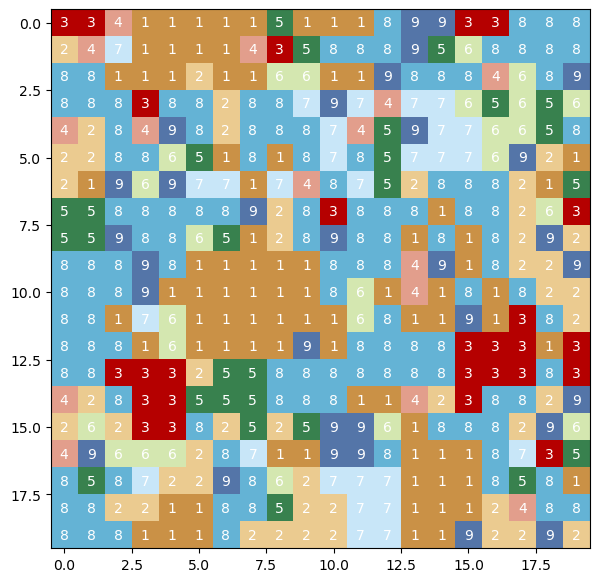

In [115]:
unique, counts=np.unique(pattern_generated_random_lu_area, return_counts=True)
unique_counts=dict(zip(unique, counts))
print(unique_counts)
usda_vis.imshow_label2darray(pattern_generated_random_lu_area,figsize=(7,7),cmap=cmap_LC,norm=norm,fontsize=10)

* 随机初始化种群的多目标空间规划

随机初始化种群，迭代5000次，从空间目标上判断，土地利用类型的破碎化程度减小，最大簇相对大小有所改善，紧密度增加，对应的值分别为38，6.185和0.347，与最初设置的目标值（取了最大和最小值的中间值，分别为27，5.4和0.5）接近；从准则目标上判断，自然价值、娱乐休闲价值和土地利用类型转换成本依次为2332、2054和-15840.0，而最初设置的目标值为2200、2200和-1940000.0，其中自然价值、娱乐休闲价值接近目标值，土地利用转换成本只要小于0就满足要求，因此准则目标也达到了最初设置的目标值；对于土地利用类型的数量空值，计算结果为`{1: 135, 2: 38, 3: 28, 4: 7, 5: 3, 6: 1, 7: 21, 8: 143, 9: 24}`，均位于最初指定的区间内。因此，可以判断应用遗传算法于多目标空间决策是可行的，其计算结果能够为空间规划提供参照。

Generation = 0;	 f(x) = 1.5770013236205606e+22
Generation = 500;	 f(x) = 43.99567511055381
Generation = 1000;	 f(x) = 27.804721274539045
Generation = 1500;	 f(x) = 25.13594265347618
Generation = 2000;	 f(x) = 25.13594265347618
Generation = 2500;	 f(x) = 25.13594265347618
Generation = 3000;	 f(x) = 25.13594265347618
Generation = 3500;	 f(x) = 25.13594265347618
Generation = 4000;	 f(x) = 24.67886469436648
Generation = 4500;	 f(x) = 23.440904167399868
Generation = 5000;	 f(x) = 23.440904167399868


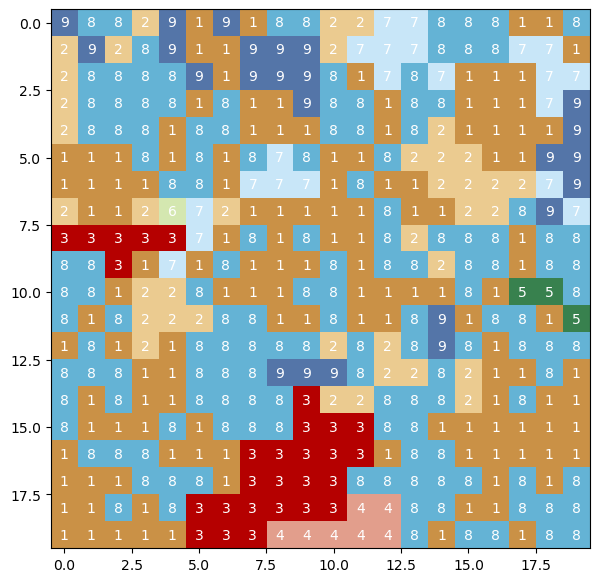

In [103]:
cost_filter=['natrue_cost','recreation_cost','lu_conversion_cost','C','L','R','lu_area_cost']

pattern_generated_random,epoch=usda_heuristicsw.genetic_algorithm_2d_fixed_map(
        objects_idx,
        rows_n=rows_n,
        cols_n=cols_n,
        population_size=50,
        generations=5001,
        mutation_rate=0.5,
        target_function=target_function_jisperveld_plan,
        crossover_name='crossover_CBO',
        mutation_name='mutation_MPO_MBO', 
        mpo_mbo='mpo',
        fixed_map=fixed_map,
        verbose=500)

usda_vis.imshow_label2darray(pattern_generated_random,figsize=(7,7),cmap=cmap_LC,norm=norm,fontsize=10)

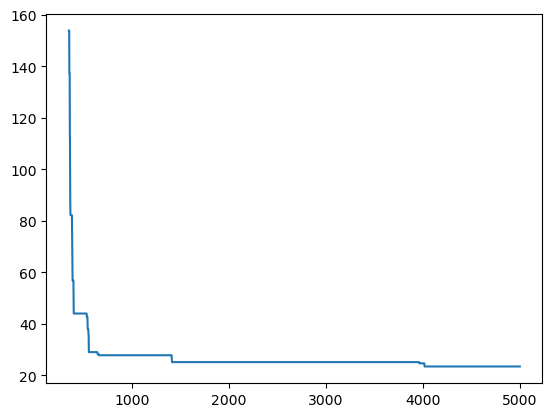

In [111]:
fig, ax=plt.subplots()
ax.plot(list(epoch.keys())[350:],list(epoch.values())[350:])
plt.show()

计算最优解的准则目标、空间目标和土地利用类型数量控制值。

In [120]:
C,L,R=target_function_spatial_objectives_constrains(pattern_generated_random)    
print(C,L,R)

nature_cost,recreation_cost,conversion_cost=target_function_additive_objectives_constrains(pattern_generated_random)
print(nature_cost,recreation_cost,conversion_cost)

unique, counts=np.unique(pattern_generated_random, return_counts=True)
unique_counts=dict(zip(unique, counts))
print(unique_counts)

38 6.185158116737064 0.3478124999999978
2332 2054 -15840.0
{1: 135, 2: 38, 3: 28, 4: 7, 5: 3, 6: 1, 7: 21, 8: 143, 9: 24}


**D - 基于标记距离的2维度布局生成**

下面进行了一个单个空间目标的实验，以最小化到一个土地利用或土地覆盖样方类/簇大小直方图标记特征的距离为目标，通过2维度遗传算法，使生成的样方类/簇大小直方图标记特征趋近于已知的样方，并调大了样方的大小，由之前实验的 20×20 的栅格数据，扩大为 100×100，观察成本值收敛情况。从计算结果来看，最优解到已知样方的距离为0.0849，所用的Jensen-Shannon距离区间为[0,1]，当值趋近于0时，两个样方的类/簇大小直方图标记特征基本相同，同时，随着迭代次数的增加，成本值为缓慢下降趋势，因此表明2维度标记特征用于空间目标是可行的。

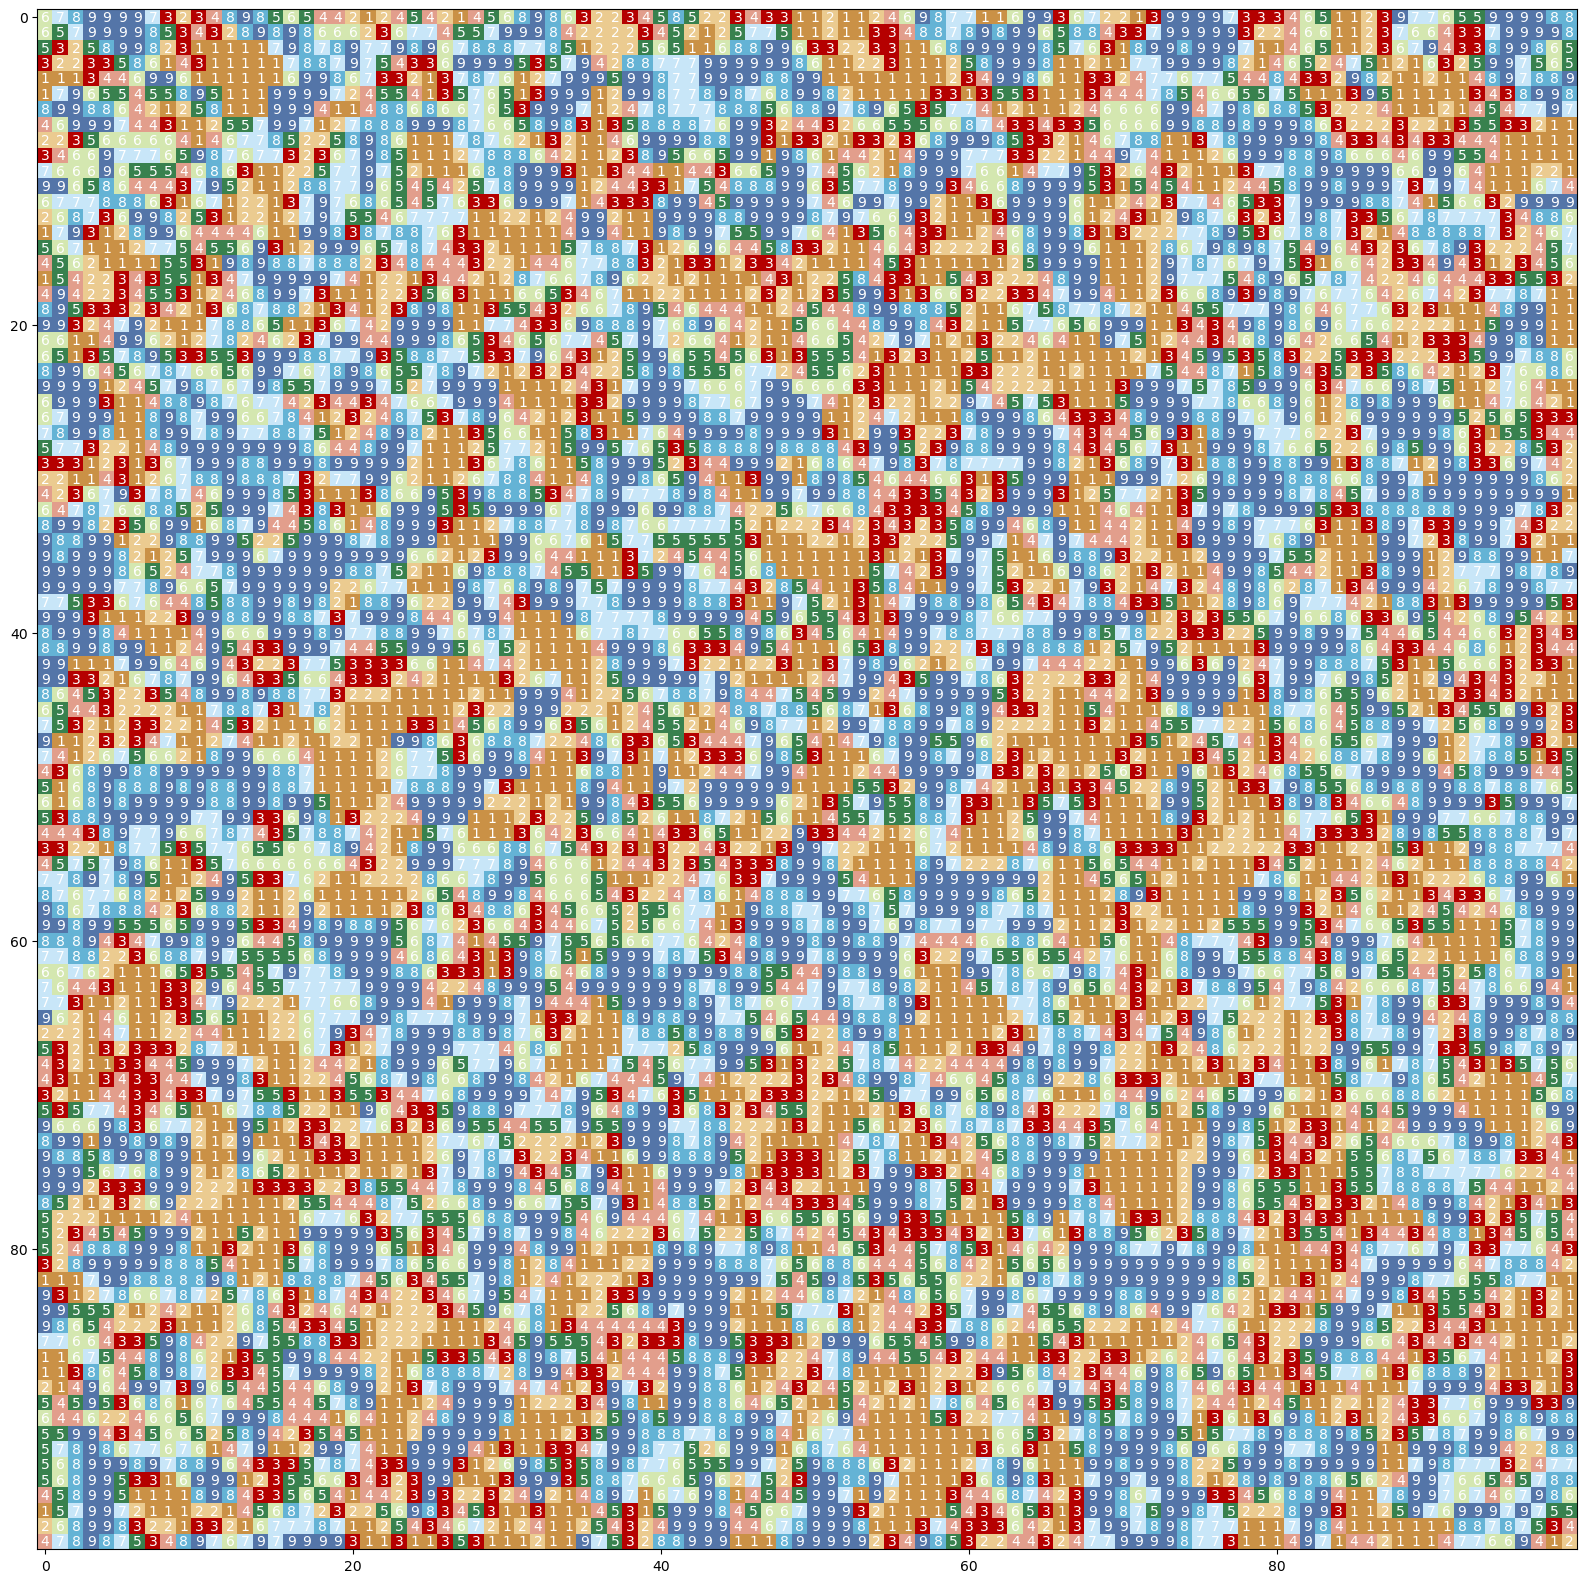

In [135]:
size=100
X,_=usda_datasets.generate_categorical_2darray(size=size,seed=99)
X4=mapclassify.FisherJenks(X[0], k=9).yb.reshape(size,size)+1
usda_vis.imshow_label2darray(X4,figsize=(20,20),fontsize=10,cmap=cmap_LC,norm=norm)  

定义基于类/簇大小直方图标记特征距离的目标函数。

In [131]:
def target_function_class_clumpSize(quadrat):
    global compared_quadradt    

    q1_cc=cc3d.connected_components(quadrat,connectivity=8,return_N=False,out_dtype=np.uint64)
    q1_cs=usda_signature.class_clumpSize_histogram(quadrat,q1_cc)   
    
    q2_cc=cc3d.connected_components(compared_quadradt, connectivity=8,return_N=False,out_dtype=np.uint64)
    q2_cs=usda_signature.class_clumpSize_histogram(compared_quadradt,q2_cc)       
    
    q1_cs_pdf=q1_cs/q1_cs.values.sum()
    q2_cs_pdf=q2_cs/q2_cs.values.sum()

    q1_cs_pdf,q2_cs_pdf=usda_utils.complete_dataframe_rowcols([q1_cs_pdf,q2_cs_pdf])     
    
    class_clumpSize_pdf_shannon=usda_signature.Distances(q1_cs_pdf.to_numpy().flatten(),q2_cs_pdf.to_numpy().flatten())
    distance=class_clumpSize_pdf_shannon.shannon()['Jensen-Shan']

    return distance

基于2维遗传算法求解。

In [142]:
objects_idx=list(range(1,10))
rows_n=size
cols_n=size
compared_quadradt=copy.deepcopy(X4)

pattern_generated,epoch=usda_heuristicsw.genetic_algorithm_2d_fixed_map(
    objects_idx,
    rows_n=rows_n,
    cols_n=cols_n,
    population_size=50,
    generations=1000,
    mutation_rate=0.5,
    target_function=target_function_class_clumpSize,
    crossover_name='crossover_CBO',
    mutation_name='mutation_MPO_MBO', 
    mpo_mbo='mpo',
    verbose=200)

Generation = 0;	 f(x) = 0.1256898055950527
Generation = 200;	 f(x) = 0.1022821600839174
Generation = 400;	 f(x) = 0.09489259290469998
Generation = 600;	 f(x) = 0.09020153855631115
Generation = 800;	 f(x) = 0.08491062724665702


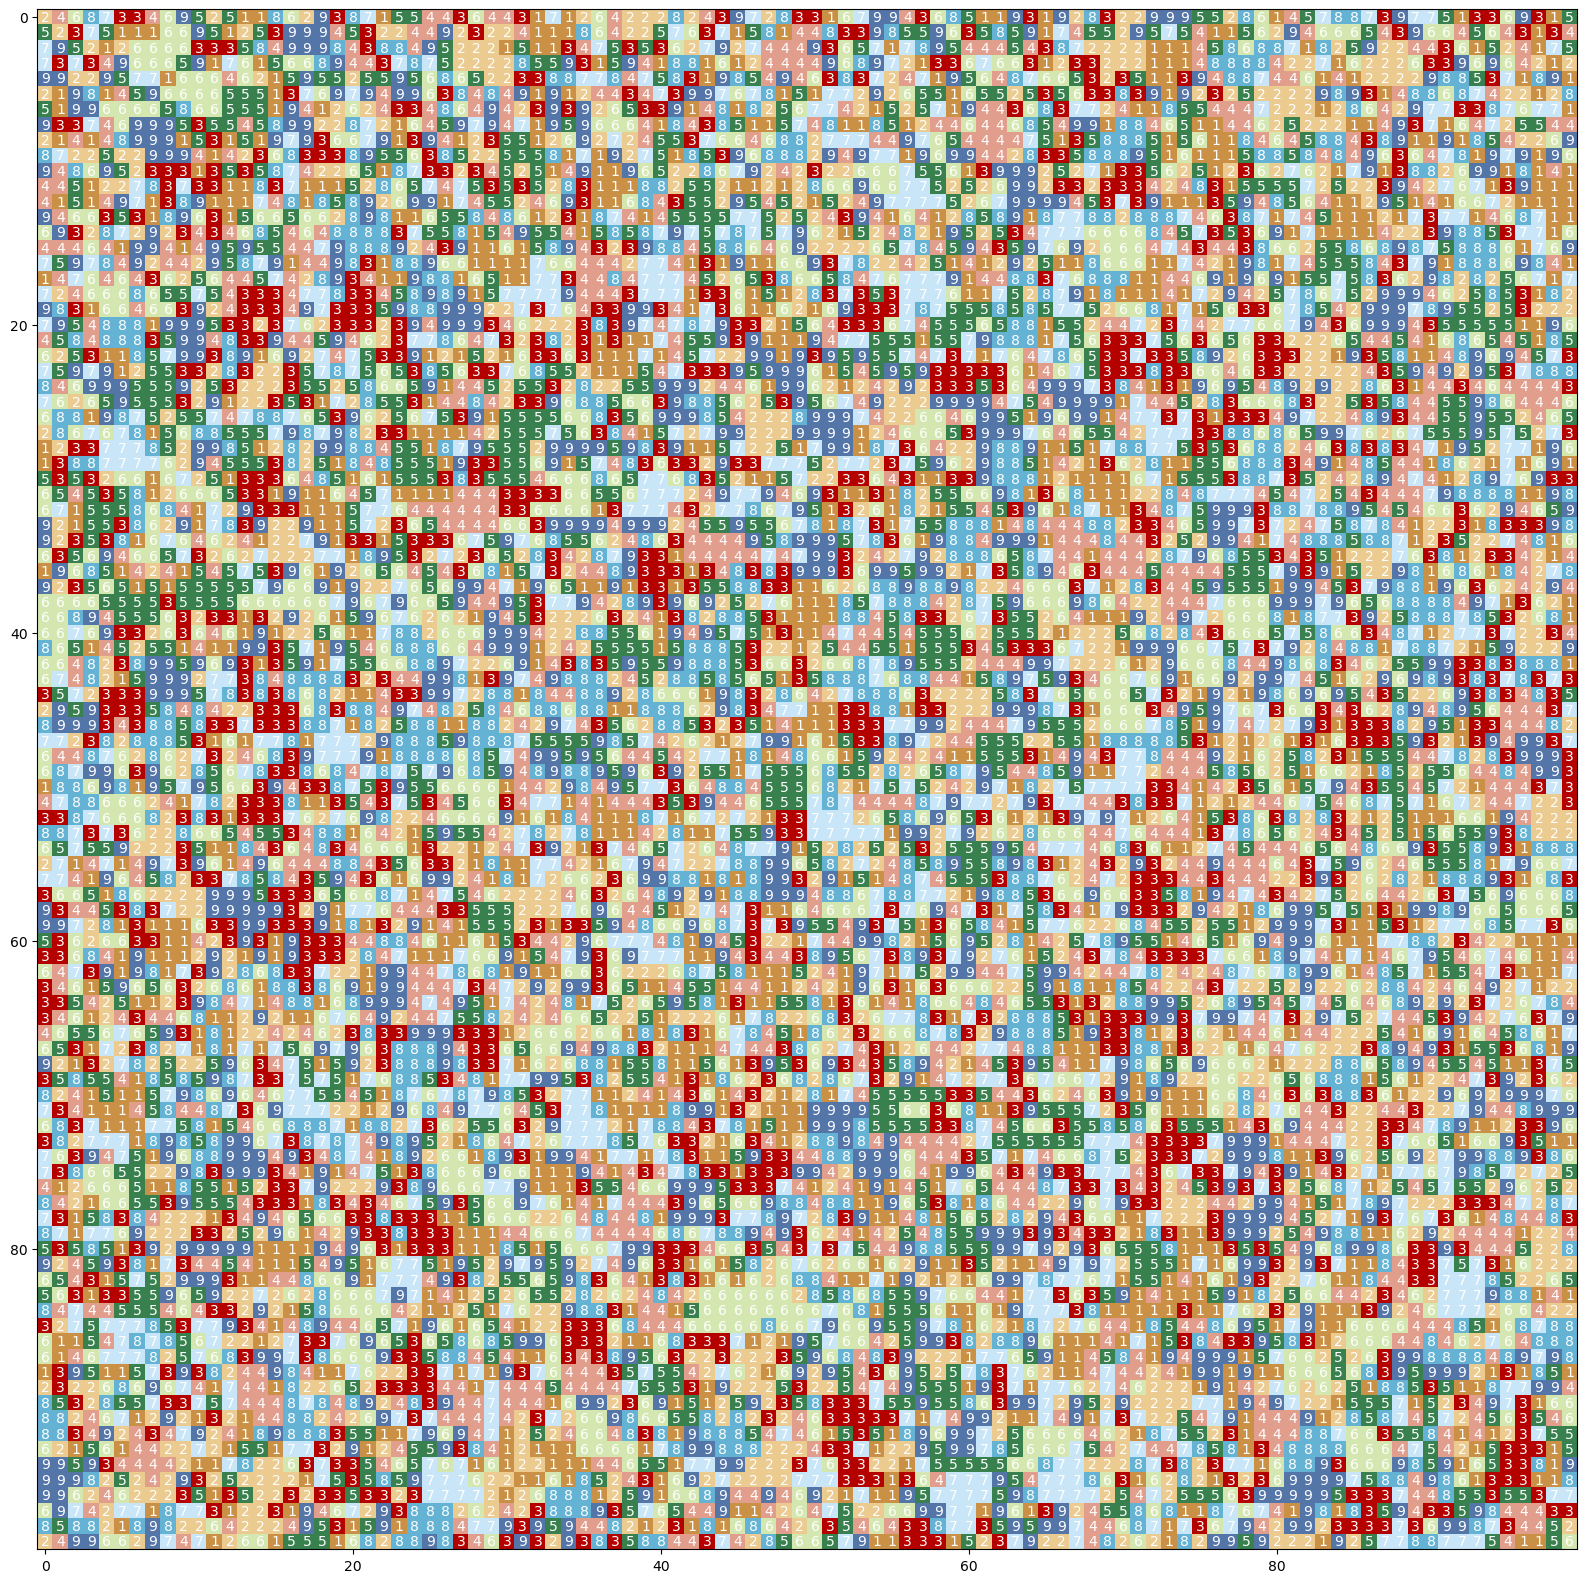

In [143]:
usda_vis.imshow_label2darray(pattern_generated,figsize=(20,20),fontsize=10,cmap=cmap_LC,norm=norm) 

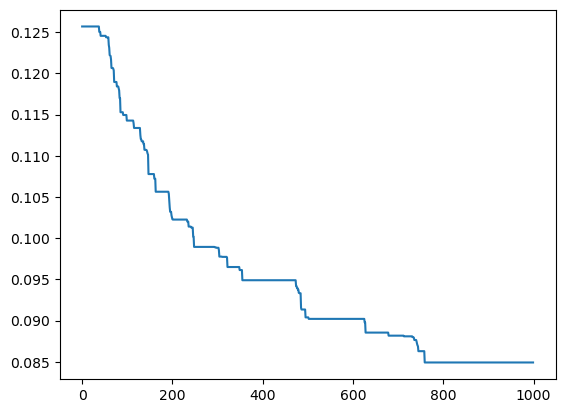

In [144]:
fig, ax=plt.subplots()
ax.plot(epoch.keys(),epoch.values())
plt.show()

## 3.3.2 元启发式算法（Meta-Heuristic Algorithm）

|序号  | 算法名  | 参考论文  | 备注  |
|---|---|---|---|
|  1 | Adaptive Random Search  | Adaptive random search methods for simulation optimization<sup>[Prudius, Andrei A. Adaptive random search methods for simulation optimization. Georgia Institute of Technology ProQuest Dissertations Publishing,  2007. 3271580. ]</sup>  |   |
|  2 | Ant Lion Optimizer   | The Ant Lion Optimizer<sup>[Mirjalili, S. The ant lion optimizer. Advances in Engineering Software 83, 80–98 (2015).]</sup>  |   |
|  3 |  Arithmetic Optimization Algorithm | The Arithmetic Optimization Algorithm<sup>[Abualigah, L., Diabat, A., Mirjalili, S., Abd Elaziz, M. & Gandomi, A. H. The Arithmetic Optimization Algorithm. Comput Methods Appl Mech Eng 376, (2021).]</sup>  |   |
| 4  | Artificial Bee Colony Optimization  | An Idea Based on Honey Bee Swarm for Numerical Optimization<sup>[Karaboga, D. An Idea Based on Honey Bee Swarm for Numerical Optimization, Technical Report - TR06. Technical Report, Erciyes University (2005).]</sup>  |   |
| 5  | Artificial Fish Swarm Algorithm  | 一种基于动物自治体的寻优模式:鱼群算法<sup>[李晓磊,邵之江,钱积新.一种基于动物自治体的寻优模式:鱼群算法[J].系统工程理论与实践,2002(11):32-38.]</sup>  |   |
| 6  | Bat Algorithm  | A New Metaheuristic Bat-Inspired Algorithm<sup>[Yang, X.-S. A New Metaheuristic Bat-Inspired Algorithm, in: Nature Inspired Coop-erative Strategies for Optimization. vol. 284 (2010).]</sup>  |   |
| 7  | Biogeography Based Optimization  |  Biogeography-based optimization<sup>[Simon, D. Biogeography-based optimization. IEEE Transactions on Evolutionary Computation 12, 702–713 (2008).]</sup> |   |
|  8 | Cross-Entropy Method  | Optimization of computer simulation models with rare events<sup>[Rubinstein, R. Y. EUROPEAN JOURNAL OF OPERATIONAL Optimization of computer simulation models with rare events *. European Journal of Operational Research vol. 99 (1997).]</sup>  |   |
|  9 | Crow Search Algorithm   |  A novel metaheuristic method for solving constrained engineering optimization problems: Crow search algorithm<sup>[Askarzadeh, A. A novel metaheuristic method for solving constrained engineering optimization problems: Crow search algorithm. Comput Struct 169, 1–12 (2016).]</sup> |   |
| 10  | Cuckoo Search  | Cuckoo Search via Levy Flights<sup>[Yang, X.-S. & Deb, S. Cuckoo Search via Levy Flights. (2010) doi:10.48550/ARXIV.1003.1594.]</sup>  |   |
|  11 | Differential Evolution  | Differential Evolution-A Simple and Efficient Heuristic for Global Optimization over Continuous Spaces<sup>[Storn, R. & Price, K. Differential Evolution-A Simple and Efficient Heuristic for Global Optimization over Continuous Spaces. Journal of Global Optimization vol. 11 (1997).]</sup>  |   |
| 12  | Dispersive Flies Optimization   |  Dispersive flies optimisation and medical imaging<sup>[al-Rifaie, M. M. & Aber, A. Dispersive flies optimisation and medical imaging. Studies in Computational Intelligence 610, 183–203 (2016).]</sup> |   |
| 13  | Dragonfly Algorithm  | Dragonfly algorithm: a comprehensive review and applications<sup>[Meraihi, Y., Ramdane-Cherif, A., Acheli, D. & Mahseur, M. Dragonfly algorithm: a comprehensive review and applications. Neural Computing and Applications vol. 32 16625–16646 Preprint at https://doi.org/10.1007/s00521-020-04866-y (2020).]</sup>  |   |
| 14  | Firefly Algorithm  |   Nature-inspired optimization algorithms<sup>[Yang, X.-She. Nature-inspired optimization algorithms. Elsevier Inc, (2014).]</sup> |   |
| 15  | Flow Direction Algorithm   |  Flow Direction Algorithm (FDA): a Novel Optimizer Approach for Solving Optimization Problems<sup>[Karami, H., Valikhan Anaraki, M., Farzin, S. & Mirjalili, S. Flow Direction Algorithm (FDA): a Novel Optimizer Approach for Solving Optimization Problems. Comput Ind Eng 156, 107224 (2021).]</sup> |   |
| 16  | Flower Pollination Algorithm  |  Nature-inspired optimization algorithms<sup>[]</sup> |   |
| 17  | Genetic Algorithm  |  Adaptation in Natural and Artificial Systems_ An Introductory Analysis with Applications to Biology, Control, and Artificial Intelligence<sup>[John H. Holland. Adaptation in Natural and Artificial Systems_ An Introductory Analysis with Applications to Biology, Control, and Artificial Intelligence-MIT (1992) .]</sup> |   |
| 18  | Grey Wolf Optimizer  | Grey Wolf Optimizer<sup>[Mirjalili, S., Mirjalili, S. M. & Lewis, A. Grey Wolf Optimizer. Advances in Engineering Software 69, 46–61 (2014).]</sup>  |   |
| 19  | Grasshopper Optimization Algorithm  | Grasshopper Optimisation Algorithm: Theory and application<sup>[Saremi, S., Mirjalili, S. & Lewis, A. Grasshopper Optimisation Algorithm: Theory and application. Advances in Engineering Software 105, 30–47 (2017).]</sup>  |   |
| 20  | Gravitational Search Algorithm  |  GSA: A Gravitational Search Algorithm<sup>[Rashedi, E., Nezamabadi-pour, H. & Saryazdi, S. GSA: A Gravitational Search Algorithm. Inf Sci (N Y) 179, 2232–2248 (2009).]</sup> |   |
| 21  | Harris Hawks Optimization  |  Harris hawks optimization: Algorithm and applications<sup>[Heidari, A. A. et al. Harris hawks optimization: Algorithm and applications. Future Generation Computer Systems 97, 849–872 (2019).]</sup> |   |
| 22  | Improved Grey Wolf Optimizer  | An improved grey wolf optimizer for solving engineering problems<sup>[Nadimi-Shahraki, M. H., Taghian, S. & Mirjalili, S. An improved grey wolf optimizer for solving engineering problems. Expert Syst Appl 166, (2021).]</sup>  |   |
| 23  | Improved Whale Optimization Algorithm  | IWOA: An improved whale optimization algorithm for optimization problems<sup>[Mostafa Bozorgi, S. & Yazdani, S. IWOA: An improved whale optimization algorithm for optimization problems. J Comput Des Eng 6, 243–259 (2019).]</sup>  |   |
| 24  | Jaya   | Jaya: A simple and new optimization algorithm for solving constrained and unconstrained optimization problems<sup>[Venkata Rao, R. Jaya: A simple and new optimization algorithm for solving constrained and unconstrained optimization problems. International Journal of Industrial Engineering Computations 7, 19–34 (2016).]</sup>  |   |
| 25  | Jellyfish Search Optimizer  | A novel metaheuristic optimizer inspired by behavior of jellyfish in ocean<sup>[Chou, J. S. & Truong, D. N. A novel metaheuristic optimizer inspired by behavior of jellyfish in ocean. Appl Math Comput 389, (2021).]</sup>  |   |
|  26 | Krill Herd Algorithm  | A comprehensive review: Krill Herd algorithm (KH) and its applications<sup>[Bolaji, A. L. aro, Al-Betar, M. A., Awadallah, M. A., Khader, A. T. & Abualigah, L. M. A comprehensive review: Krill Herd algorithm (KH) and its applications. Applied Soft Computing Journal vol. 49 437–446 Preprint at https://doi.org/10.1016/j.asoc.2016.08.041 (2016).]</sup>  |   |
|  27 | Memetic Algorithm  |   On Evolution, Search, Optimization, Genetic Algorithms and Martial Arts: Towards Memetic Algorithms<sup>[Moscato, P. On Evolution, Search, Optimization, Genetic Algorithms and Martial Arts: Towards Memetic Algorithms. (1989).]</sup> |   |
|  28 | Moth Flame Optimization  |  Moth-flame optimization algorithm: A novel nature-inspired heuristic paradigm<sup>[Mirjalili, S. Moth-flame optimization algorithm: A novel nature-inspired heuristic paradigm. Knowl Based Syst 89, 228–249 (2015).]</sup> |   |
| 29  | Multiverse Optimizer  | Multi-Verse Optimizer: a nature-inspired algorithm for global optimization<sup>[Mirjalili, S., Mirjalili, S. M. & Hatamlou, A. Multi-Verse Optimizer: a nature-inspired algorithm for global optimization. Neural Comput Appl 27, 495–513 (2016).]</sup>  |   |
| 30  |Pathfinder Algorithm   | A new meta-heuristic optimizer: Pathfinder algorithm<sup>[Yapici, H. & Cetinkaya, N. A new meta-heuristic optimizer: Pathfinder algorithm. Applied Soft Computing Journal 78, 545–568 (2019).]</sup>  |   |
| 31  | Particle Swarm Optimization  |  Particle swarm optimization<sup>[Kennedy, J. & Eberhart, R. Particle swarm optimization. in Proceedings of ICNN’95 - International Conference on Neural Networks vol. 4 1942–1948 vol.4 (1995).]</sup>  |   |
| 32  | Random Search   | Recent Advances in Finding Best Operating Conditions<sup>[Anderson, R. L. RECENT ADVANCES IN FINDING BEST OPERATING CONDITIONS*. Source: Journal of the American Statistical Association vol. 48 (1953).]</sup>  |   |
| 33  | Salp Swarm Algorithm  |  Salp Swarm Algorithm: A bio-inspired optimizer for engineering design problems<sup>[Mirjalili, S. et al. Salp Swarm Algorithm: A bio-inspired optimizer for engineering design problems. Advances in Engineering Software 114, 163–191 (2017).]</sup>  |   |
| 34  |Simulated Annealing   | Optimization by Simulated Annealing<sup>[Kirkpatrick, S., Gelatt, C. D. & Vecchi, M. P. Optimization by Simulated Annealing Downloaded from. vol. 220 http://science.sciencemag.org/ (1983).]</sup>  |   |
| 35  | Sine Cosine Algorithm  | A Sine Cosine Algorithm for solving optimization problems<sup>[Mirjalili, S. SCA: A Sine Cosine Algorithm for solving optimization problems. Knowl Based Syst 96, 120–133 (2016).]</sup>  |   |
| 36  |Student Psychology Based Optimization   |  Student psychology based optimization algorithm: A new population based optimization algorithm for solving optimization problems<sup>[Das, B., Mukherjee, V. & Das, D. Student psychology based optimization algorithm: A new population based optimization algorithm for solving optimization problems. Advances in Engineering Software 146, (2020).]</sup> |   |
|37   | Symbiotic Organisms Search  | Symbiotic Organisms Search: A new metaheuristic optimization algorithm<sup>[Cheng, M. Y. & Prayogo, D. Symbiotic Organisms Search: A new metaheuristic optimization algorithm. Comput Struct 139, 98–112 (2014).]</sup>  |   |
| 38  |Teaching Learning Based Optimization   | Teaching-learning-based optimization: A novel method for constrained mechanical design optimization problems<sup>[Rao, R. V., Savsani, V. J. & Vakharia, D. P. Teaching-learning-based optimization: A novel method for constrained mechanical design optimization problems. CAD Computer Aided Design 43, 303–315 (2011).]</sup>  |   |
| 39  | Whale Optimization Algorithm  | The Whale Optimization Algorithm <sup>[Mirjalili, S. & Lewis, A. The Whale Optimization Algorithm. Advances in Engineering Software 95, 51–67 (2016).]</sup> |   |

### 3.3.2.1 粒子群优化算法（Particle Swarm Optimization, PSO）

元启发式算法通常存在类似的表述，对于解（solution，为1维到多维的向量），遗传算法（GA）表述为染色体（chromosome），灰狼算法（GWO）表述为灰狼，粒子群（PSO）算法表述为粒子；对于多个解组成的集群，GA表述为种群（population），GWO表述为狼群位置（position（swarm）），PSO表述为粒子群位置（position（swarm））。GA初始化时仅需要初始化种群（随机多个解），PSO初始化时则初始化粒子群位置（随机多个解）同时，需要初始化对应粒子位置的速度向量。一个粒子的位置向量（解）表述为$x_i=\left[x_i^1, x_i^2, \ldots, x_i^D\right]$；对应的一个粒子速度向量为$v_i=\left[v_i^1, v_i^2, \ldots, v_i^D\right]$，式中，$i$表示粒子的序号，$D$表示求解问题的维数。求解过程中存在两个关键向量（解），一个是各个粒子自身的历史（局部）最优解（pBest）；另一个是全局（所有粒子）的最优解（gBest），每次迭代过程中各个粒子的位置向量更新计算公式为：$\begin{aligned} & v_i^d  =\omega \times v_i^d+c_1 \times \operatorname{rand}_1^d \times\left(p B e s t_1^d-x_i^d\right)+c_2 \times \operatorname{rand}_2^d \times\left(g \text { Best }^d-x_i^d\right) \\ & x_i^d=x_i^d+v_i^d\end{aligned}$，式中，$\omega \times v_i^d$部分为惯性（inertia），使得粒子沿原有相同方向和相同大小运动，发现有潜在最优解的区域，寻找新解。$\omega$为惯性权重，为正的常数，通过调整其值的大小，用于平衡全局搜索（global search/exploration）（趋于高值）和局部搜索（local search/exploitation）（趋于低值）。$c_1 \times \operatorname{rand}_1^d \times\left(p B e s t_1^d-x_i^d\right)$部分为粒子自我认知（personal influence）部分，比较粒子历史最优解与当前解的距离。$c_1$为一个正常数，为个体认知参数，$\operatorname{rand}_1^d $为[0,1]之间的随机数，增加搜索的随机性。$c_2 \times \operatorname{rand}_2^d \times\left(g \text { Best }^d-x_i^d\right)$部分为社会经验（social influence）部分，比较全局最优解与当前解的距离。$c_2$为社会学习参数，$\operatorname{rand}_2^d$为[0,1]之间的随机数，增加搜索的随机性。当$c_1=c_2=0$时，所有粒子继续沿各自当前方向飞行，直至达到搜索空间的边界；当$c_1>0,c_2=0$时，所有粒子都是独立的；当$c_2>0,c_1=0$时，所有粒子都被吸引到整个群中的一个点（gBest）；当$c_1=c_2 \neq 0$时，所有粒子都被吸引到pBest和gBest的均值位置。

位置向量更新计算公式代码表述为：

```python
# Function: Velocity
def velocity_vector(position, init_velocity, i_b_matrix, best_global, w = 0.5, c1 = 2, c2 = 2):
    r1       = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)
    r2       = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)
    velocity = np.zeros((position.shape[0], init_velocity.shape[1]))
    for i in range(0, init_velocity.shape[0]):
        for j in range(0, init_velocity.shape[1]):
            velocity[i,j] = w*init_velocity[i,j] + c1*r1*(i_b_matrix[i,j] - position[i,j]) + c2*r2*(best_global[j] - position[i,j])
    return velocity

# Function: Updtade Position
def update_position(position, velocity, min_values = [-5,-5], max_values = [5,5], target_function = target_function):
    for i in range(0, position.shape[0]):
        for j in range(0, position.shape[1] - 1):
            position[i,j] = np.clip((position[i,j] + velocity[i,j]),  min_values[j],  max_values[j])
        position[i,-1] = target_function(position[i,0:position.shape[1]-1])
    return position
```

Valdecy Pereira 在测试 PSO 时选择了 Easom 函数：$f(\mathbf{x})=-\cos \left(x_1\right) \cos \left(x_2\right) \exp \left(-\left(x_1-\pi\right)^2-\left(x_2-\pi\right)^2\right)$作为目标函数，计算结果如下。

In [2]:
def easom(variables_values = [0, 0]):
    x1, x2     = variables_values
    func_value = -np.cos(x1) * np.cos(x2) * np.exp(-(x1 - np.pi) ** 2 - (x2 - np.pi) ** 2)
    return func_value

parameters = {
    'swarm_size': 250,
    'min_values': (-5, -5),
    'max_values': (5, 5),
    'iterations': 500,
    'decay': 0,
    'w': 0.9,
    'c1': 2,
    'c2': 2,
    'verbose': 100
} 
pso,epoch =usda_heuristic.particle_swarm_optimization(target_function = easom, **parameters)
# PSO - Solution
variables = pso[:-1]
minimum   = pso[ -1]
print('Variables: ', np.around(variables, 4) , ' Minimum Value Found: ', round(minimum, 4) )

Iteration =  0  f(x) =  -0.6409483703488887
Iteration =  100  f(x) =  -0.9998786813759035
Iteration =  200  f(x) =  -0.999999903656637
Iteration =  300  f(x) =  -0.999999903656637
Iteration =  400  f(x) =  -0.999999903656637
Iteration =  500  f(x) =  -0.999999903656637
Variables:  [3.1418 3.1418]  Minimum Value Found:  -1.0


In [5]:
# PSO - Plot Solution
plot_parameters = {
    'min_values': (-5, -5),
    'max_values': (5, 5),
    'step': (0.1, 0.1),
    'solution': [variables],
    'proj_view': '3D',
    'view': 'browser' # 'notebook'
}
usda_vis.plot_single_function(target_function = easom, **plot_parameters)

通过绘制函数2维分布，可以发现最优解的位置，位于最低端红点处。

<img src="../imgs/3_3/3_3_04.png" height='auto' width='500' title="caDesign">

* 基准函数（benchmark functions）

Mirjalili, S. <sup>[grey wolf]</sup> 总结了用于测试元启发式算法的基准函数，将其归为4组，为单峰函数（unimodal）、多峰函数（multimodal）、固定维度多峰函数（ﬁxed-dimension multimodal）和复合函数（composite functions）。下述引用表格<sup>[grey wolf]</sup>中，给出了函数（function），基准函数的维数（dimension）、函数搜索空间的边界（range）和最优值（optimum）。


单峰基准函数

| 函数  | 维数  | 边界  | 最优值  |
|---|---|---|---|
| $$f_1(x)=\sum_{i=1}^n x_i^2$$  | 30  |  [-100,100] | 0  |
| $$f_2(x)=\sum_{i=1}^n\left|x_i\right|+\prod_{i=1}^n\left|x_i\right|$$ | 30  | [-10,10]  |  0 |
| $$f_3(x)=\sum_{i=1}^n\left(\sum_{j-1}^i x_j\right)^2$$ | 30  | [-100,100]  |  0 |
| $$f_4(x)=\max _i\left\{\left|x_i\right|, 1 \leqslant i \leqslant n\right\}$$  | 30  |  [-100,100] |  0 |
| $$f_5(x)=\sum_{i=1}^{n-1}\left[100\left(x_{i+1}-x_i^2\right)^2+\left(x_i-1\right)^2\right]$$  | 30  | [-30,30]  | 0  |
| $$f_6(x)=\sum_{i=1}^n\left(\left[x_i+0.5\right]\right)^2$$  | 30  | [-100,100]  |  0 |
| $$f_7(x)=\sum_{i=1}^n i x_i^4+\operatorname{random}[0,1)$$  |  30 |  [-1.28,1.28] | 0  |

多峰基准函数

| 函数  | 维数  | 边界  | 最优值  |
|---|---|---|---|
| $$ F_8(x)=\sum_{i=1}^n-x_i \sin \left(\sqrt{\left|x_i\right|}\right)$$  |  30 | [-500,500]  |  -418.9829×5  |
| $$F_9(x)=\sum_{i=1}^n\left[x_i^2-10 \cos \left(2 \pi x_i\right)+10\right]$$  | 30  | [-5.12,5.12]  |  0 |
| $$F_{10}(x)=-20 \exp \left(-0.2 \sqrt{\frac{1}{n} \sum_{i=1}^n x_i^2}\right)-\exp \left(\frac{1}{n} \sum_{i=1}^n \cos \left(2 \pi x_i\right)\right)+20+e$$  | 30  |  [-32,32] | 0  |
| $$F_{11}(x)=\frac{1}{4000} \sum_{i=1}^n x_i^2-\prod_{i=1}^n \cos \left(\frac{x_i}{\sqrt{i}}\right)+1 $$  | 30  | [-600,600]  |  0 |
| $$ \begin{aligned} & F_{12}(x)=\frac{\pi}{n}\left\{10 \sin \left(\pi y_1\right)+\sum_{i=1}^{n-1}\left(y_i-1\right)^2\left[1+10 \sin ^2\left(\pi y_{i+1}\right)\right]+\left(y_n-1\right)^2\right\}+\sum_{i=1}^n u\left(x_i, 10,100,4\right) \\ & y_i=1+\frac{x_i+1}{4} \\ & u\left(x_i, a, k, m\right)= \begin{cases}k\left(x_i-a\right)^m & x_i>a \\ 0 & -a<x_i<a \\ k\left(-x_i-a\right)^m & x_i<-a\end{cases} \end{aligned} $$  | 30  | [-50,50]  | 0  |
|$$F_{13}(x)=0.1\left\{\sin ^2\left(3 \pi x_1\right)+\sum_{i=1}^n\left(x_i-1\right)^2\left[1+\sin ^2\left(3 \pi x_i+1\right)\right]+\left(x_n-1\right)^2\left[1+\sin ^2\left(2 \pi x_n\right)\right]\right\}+\sum_{i=1}^n u\left(x_i, 5,100,4\right)$$   | 30|  [-50,50]   | 0  |
| $$F_{14}(x)=-\sum_{i=1}^n \sin \left(x_i\right) \cdot\left(\sin \left(\frac{i x_i^2}{\pi}\right)\right)^{2 m}, m=10$$  |30   | [0,$ \pi $]  |  -4.687 |
| $$ F_{15}(x)=\left[e^{-\sum_{i=1}^n\left(x_i / \beta\right)^{2 m}}-2 e^{-\sum_{i=1}^n x_i^2}\right] \cdot \prod_{i=1}^n \cos ^2 x_i, m=5$$  | 30  |  [-20,20] |-1   |
|$$F_{16}(x)=\left\{\left[\sum_{i=1}^n \sin ^2\left(x_i\right)\right]-\exp \left(-\sum_{i=1}^n x_i^2\right)\right\} \cdot \exp \left[-\sum_{i=1}^n \sin ^2 \sqrt{\left|x_i\right|}\right]$$|30|[-10,10]|-1|

固定维度多峰基准函数

| 函数  | 维数  | 边界  | 最优值  |
|---|---|---|---|
| $$ F_{14}(x)=\left(\frac{1}{500}+\sum_{j=1}^{25} \frac{1}{j+\sum_{i=1}^2\left(x_i-a_{i j}\right)^6}\right)^{-1} $$  | 2  | [-65,65]  |  1 |
| $$F_{15}(x)=\sum_{i=1}^{11}\left[a_i-\frac{x_1\left(b_i^2+b_i x_2\right)}{b_i^2+b_i x_3+x_4}\right]^2$$  |  4 | [-5,5]  | 0.00030  |
| $$F_{16}(x)=4 x_1^2-2.1 x_1^4+\frac{1}{3} x_1^6+x_1 x_2-4 x_2^2+4 x_2^4$$  | 2  | [-5,5]  | -1.0316  |
| $$F_{17}(x)=\left(x_2-\frac{5.1}{4 \pi^2} x_1^2+\frac{5}{\pi} x_1-6\right)^2+10\left(1-\frac{1}{8 \pi}\right) \cos x_1+10$$  |  2 |   [-5,5]   |  0.398  |
| $$F_{18}(x)=\left[1+\left(x_1+x_2+1\right)^2\left(19-14 x_1+3 x_1^2-14 x_2+6 x_1 x_2+3 x_2^2\right)\right] \times\left[30+\left(2 x_1-3 x_2\right)^2 \times\left(18-32 x_1+12 x_1^2+48 x_2-36 x_1 x_2+27 x_2^2\right)\right]$$  |  2 |  [-2,2] | 3  |
| $$F_{19}(x)=-\sum_{i=1}^4 c_i \exp \left(-\sum_{j=1}^3 a_{i j}\left(x_j-p_{i j}\right)^2\right)$$  |  3 | [1,3]  |   -3.86 |
| $$F_{20}(x)=-\sum_{i=1}^4 c_i \exp \left(-\sum_{j=1}^6 a_{i j}\left(x_j-p_{i j}\right)^2\right)$$  | 6  |  [0,1] |  -3.32 |
| $$F_{21}(x)=-\sum_{i=1}^5\left[\left(X-a_i\right)\left(X-a_i\right)^T+c_i\right]^{-1}$$  |  4 | [0,10]  |  -10.1532 |
| $$F_{22}(x)=-\sum_{i=1}^7\left[\left(X-a_i\right)\left(X-a_i\right)^T+c_i\right]^{-1}$$  | 4  | [0,10]  | -10.4028  |
| $$ F_{23}(x)=-\sum_{i=1}^{10}\left[\left(X-a_i\right)\left(X-a_i\right)^T+c_i\right]^{-1}$$  |  4 | [0,10]  | -10.5363  |

复合基准函数

| 函数  | 维数  | 边界  | 最优值  |
|---|---|---|---|
| $$\begin{aligned} & F_{24}(C F 1): \\ & f_1, f_2, f_3, \ldots, f_{10}=\text { Sphere Function } \\ & {\left[\sigma_1, \sigma_2, \sigma_3, \ldots, \sigma_{10}\right]=[1,1,1, \ldots, 1]} \\ & {\left[\lambda_1, \lambda_2, \lambda_3 \ldots, \lambda_{10}\right]=[5 / 100,5 / 100,5 / 100, \ldots, 5 / 100]}  \end{aligned}$$  |  10 | [-5,5]  | 0  |
| $$\begin{aligned} & F_{25}(C F 2): \\ & f_1, f_2, f_3, \ldots, f_{10}=\text { Griewank's Function } \\ & {\left[\sigma_1, \sigma_2, \sigma_3, \ldots, \sigma_{10}\right]=[1,1,1, \ldots, 1]} \\ & {\left[\lambda_1, \lambda_2, \lambda_3, \ldots, \lambda_{10}\right]=[5 / 100,5 / 100,5 / 100, \ldots, 5 / 100]} \end{aligned}$$  |  10  |   [-5,5] | 0  |
| $\begin{aligned} & F_{26}(C F 3) \text { : } \\ & f_1, f_2, f_3, \ldots, f_{10}=\text { Griewank's Function } \\ & {\left[\sigma_1, \sigma_2, \sigma_3, \ldots, \sigma_{10}\right]=[1,1,1, \ldots, 1]} \\ & {\left[\lambda_1, \lambda_2, \lambda_3, \ldots, \lambda_{10}\right]=[1,1,1, \ldots, 1]} \end{aligned}$ |   10 |   [-5,5] |  0 |
| $$\begin{aligned} & F_{27}(C F 4): \\ & f_1, f_2=\text { Ackley's Function } \\ & f_3, f_4=\text { Rastrigin's Function } \\ & f_5, f_6=\text { Weierstras's Function } \\ & f_7, f_8=\text { Griewank's Function } \\ & f_9, f_{10}=\text { Sphere Function } \\ & {\left[\sigma_1, \sigma_2, \sigma_3, \ldots, \sigma_{10}\right]=[1,1,1, \ldots, 1]} \\ & {\left[\lambda_1, \lambda_2, \lambda_3, \ldots, \lambda_{10}\right]=[5 / 32,5 / 32,1,1,5 / 0.5,5 / 0.5,5 / 100,5 / 100,5 / 100,5 / 100]}\end{aligned}$$  |   10 |   [-5,5] |  0 |
| $$F_{28}(CF5): \\ &  f_1, f_2=Rastrigin's Function \\ & f_3, f_4=Weierstras's Function \\ & f_5, f_6=Griewank's Function \\ & f_7, f_8=Ackley's Function
\\ & f_9, f_{10}=Sphere Function \\ & \left[\sigma_1, \sigma_2, \sigma_3, \ldots, 
 sigma_{10}\right]=[1,1,1, \ldots, 1] \\ & \left[\lambda_1, \lambda_2, \lambda_3, \ldots, \lambda_{10}\right]=[1 / 5,1 / 5,5 / 0.5,5 / 0.5,5 / 100,5 / 100,5 / 32,5 / 32,5 / 100,5 / 100] \end{aligned}$$  |   10 |   [-5,5] | 0  |
| $$\begin{aligned} & f_{29}(C F 6):  \\ &  f_1, f_2=Rastrigin's Function \\ & f_3, f_4=Weierstras's Function \\ & f_5, f_6=Griewank's Function \\ & f_7, f_8=Ackley's Function \\ & f_9, f_{10}=Sphere Function \\ & \left[\sigma_1, \sigma_2, \sigma_3, \ldots, \sigma_{10}\right]=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] \\ & \left[\lambda_1, \lambda_2, \lambda_3, \ldots, \lambda_{10}\right]=[0.1 * 1 / 5,0.2 * 1 / 5,0.3 * 5 / 0.5,0.4 * 5 / 0.5,0.5 * 5 / 100,0.6 * 5 / 100,0.7 * 5 / 32,0.8 * 5 / 32,0.9 * 5 / 100,1 * 5 / 100] \end{aligned}$$  | 10   |  [-5,5]  |  0 |


从上面选择了一个基础的基准函数$F_{16}$，再次测试 PSO， 其计算结果为 -1.0316，这与上述给出的最优解同。

In [9]:
def f_16(variables_values = [0, 0]):
    x1, x2=variables_values
    func_value=4*pow(x1,2)-2.1* pow(x1,4)+1/3*pow(x1,6)+x1*x2-4*pow(x2,2)+4*pow(x2,4)
    
    return func_value

parameters = {
    'swarm_size': 250,
    'min_values': (-5, -5),
    'max_values': (5, 5),
    'iterations': 500,
    'decay': 0,
    'w': 0.9,
    'c1': 2,
    'c2': 2,
    'verbose': 100
} 
pso_f16,epoch=usda_heuristic.particle_swarm_optimization(target_function = f_16, **parameters)
# PSO - Solution
variables = pso_f16[:-1]
minimum   = pso_f16[ -1]
print('Variables: ', np.around(variables, 4) , ' Minimum Value Found: ', round(minimum, 4) )

Iteration =  0  f(x) =  -0.9384786598518445
Iteration =  100  f(x) =  -1.0313622604609696
Iteration =  200  f(x) =  -1.0315996120260253
Iteration =  300  f(x) =  -1.03160271424224
Iteration =  400  f(x) =  -1.0316119571982225
Iteration =  500  f(x) =  -1.0316119571982225
Variables:  [ 0.0878 -0.7128]  Minimum Value Found:  -1.0316


In [11]:
plot_parameters = {
    'min_values': (-5, -5),
    'max_values': (5, 5),
    'step': (0.1, 0.1),
    'solution': [variables],
    'proj_view': '3D',
    'view': 'browser' # 'notebook'
}
usda_vis.plot_single_function(target_function = f_16, **plot_parameters)

<img src="../imgs/3_3/3_3_05.png" height='auto' width='500' title="caDesign">